# Bài toán dự đoán giao dịch gian lận
### **Bối cảnh**

Bộ dữ liệu này được cung cấp bởi Vesta Corporation - một công ty dịch vụ thanh toán (Payment Service Provider - PSP) hàng đầu thế giới.

Vesta cung cấp dịch vụ "Zero Fraud Guarantee" (Bảo đảm không gian lận). Do vậy,nếu Vesta gật đầu cho giao dịch đi qua -> Giao dịch thành công. Nếu gật đầu không đúng và để giao dịch gian lận đi qua thì Vesta phải đền bù

Nhãn isFraud=1 trong dataset này chính là nỗi đau mất tiền của Vesta. Mục tiêu của họ không chỉ là bắt fraud, mà là tối đa hóa doanh thu (cho phép nhiều giao dịch hợp lệ nhất có thể) trong khi giảm thiểu số tiền phải đền bù. Từ đó bảo vệ được doanh thu cũng như trải nghiệm người dùng.

### **Mục tiêu** 

Dựa vào bối cảnh, Cần thiết phải xây dựng một mô hình trả về xác suất là một giao dịch thương mại là gian lận được lựa chọn dựa trên các metrics sau (cập nhật thêm)

**Model evaluation metrics:**

- Primary metric: PR-AUC

**Business metrics**: 

    TODO: Tìm hiểu về các business metrics phù hợp.

### **Dữ liệu đầu vào:** 
Bao gồm 2 bảng chính được join theo TransactionId; Không phải TransactionId nào cũng có Identity Information. 

[Mô tả tổng quát về dữ liệu](https://www.kaggle.com/competitions/ieee-fraud-detection/data)

#### Bảng Transaction: Gồm thông tin giao dịch nói chung 

- Feature `TransactionDT`: Timedelta từ một cái thời gian tham chiếu được ẩn đi.

- Feature `TransactionAMT`: Lượng tiền (đơn vị USD) được giao dịch.

- Nhóm thẻ `card` (n=6): Thông tin thanh toán liên quan tới thẻ như 'loại thẻ'(card type), 'nhóm thẻ' (card category), 'ngân hàng phát hành' (issuing bank), 'quốc gia' (country), etc.

- Nhóm địa chỉ `addr` (n=2) (theo [Kaggle - Tudor Lapusan](https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203#610146)): Đều là 'địa chỉ' của người chuyển tiền, trong đó:

    `addr1`: 'Vùng thanh toán' (Billing region).

    `addr2`: 'Quốc gia thanh toán' (Billing country).

- Nhóm `email`: 
    Gồm tên miền email của cả người chuyển (`P_emaildomain`) và của người nhận (`R_emaildomain`). Có một số giao dịch không cần đến địa chỉ email của người nhận như mua hàng cho chính mình; mua sản phẩm số, etc.

    Nghĩa là trong bối cảnh giao dịch 'liêm', có hai trường người gửi và người nhận tương đương với chuyển tiền A -> B. Khi trường người nhận mất, rất có thể là thanh toán mua đồ cho mình.

- Nhóm Match `M1->M9`: Có thể hiểu là các thao tác đối chiếu như tên trên thẻ và trên địa chỉ email, etc. Hoặc là giống, hoặc là khác.

- Nhóm Count `C1->C14`: Đếm tần xuất của một cái gì đó; bị giấu ý nghĩa rồi nên chịu.

- Nhóm Timedelta `D1->D15`: Khoảng cách về mặt thời gian giữa hai cái gì đó liên quan tới giao dịch.

- Nhóm `Vxxx`: Vesta engineered rich features, bị ẩn ý nghĩa.

#### Bảng Idenity:  Gồm những thông tin về identity của giao dịch

Dữ liệu được lấy từ thông tin mạng (IP, ISP, Proxy, etc.) và 'digital signature' (UA/browser/os/version, etc) đi cùng với transaction; không phải TransactionId nào cũng có thông tin ở bảng này.

- “id01 to id11 are numerical features for identity, which is collected by Vesta and security partners such as device rating, ip_domain rating, proxy rating, etc. Also it recorded behavioral fingerprint like account login times/failed to login times, how long an account stayed on the page, etc. All of these are not able to elaborate due to security partner T&C. I hope you could get basic meaning of these features, and by mentioning them as numerical/categorical, you won't deal with them inappropriately.” (TODO: Nhớ dịch cái này)

# Load libraries

In [1]:
import polars as pl 
import polars.selectors as cs
import pandas as pd

pl.Config.set_tbl_rows(100)
pl.Config.set_tbl_cols(100)

import matplotlib.pyplot as plt
import seaborn as sns
from visualization import *
from scipy.fft import fft
import numpy as np 
from collections import Counter 


import datetime
import warnings 
warnings.filterwarnings("ignore")
from path import *
SEED = 13_03_2006
pl.set_random_seed(SEED)

# Load data

In [2]:
train_ratio = 0.8
general_data_path = INTERIM_DATA_DIR / "general.parquet"
holdout_data_path = INTERIM_DATA_DIR / "holdout.parquet"
    
if not general_data_path.exists():
    tran_df = pl.read_csv(RAW_DATA_DIR / "transaction.csv")
    iden_df = pl.read_csv(RAW_DATA_DIR / "identity.csv")
    iden_df = iden_df.with_columns(
        pl.lit(1).cast(pl.UInt8).alias("has_identity")
    )
    df = tran_df.join(iden_df, on="TransactionID", how="left")
    C_cols = [col for col in df.columns if col.startswith("C")]
    
    df = df.select(
        pl.col(pl.Float64).cast(pl.Float32),
        pl.col(pl.Int64).cast(pl.Int32),
        pl.col(pl.String).cast(pl.Categorical),
        pl.col("has_identity").cast(pl.UInt8).fill_null(0),
    )
    
    df = df.with_columns( pl.col(C_cols).cast(pl.Int32) )

    del tran_df, iden_df
    df = df.sort(by="TransactionDT", descending=False)    
    ids = range(0, df.height)
    train_ids = ids[: int(train_ratio * df.height)]
    test_ids = ids[int(train_ratio * df.height) :]
    holdout_df = df.to_pandas().iloc[test_ids]
    general_df = df.to_pandas().iloc[train_ids]
    assert holdout_df["TransactionDT"].min() > general_df["TransactionDT"].max(), "Holdout set's minimum TransactionDT is not greater than General set's maximum TransactionDT!"
    
    general_df.to_parquet(general_data_path, index=False)
    holdout_df.to_parquet(holdout_data_path, index=False)
    del df, general_df, holdout_df

# **01 - Exploratory Data Analysis**

## 01.01 - Sanity checks

In [3]:
df = pl.read_parquet(general_data_path)
print(f"Number of records: {df.height:,}")
print(f"Number of features: {df.width:,}")
print(f"Memory usage: {df.estimated_size() / 1024 ** 2:,.2f} MB")

Number of records: 472,432
Number of features: 435
Memory usage: 801.82 MB


Vì dữ liệu được điều chỉnh lại từ (float|int)64 -> (float|int)32 dựa trên khảo sát về khoảng giá trị của numeric features nên memory sử dụng tương đối ổn với khoảng 800mb RAM trên tổng 32gb RAM của máy khi join 2 table lại (Trước đó là 1.2gb RAM). 

Nhìn chung thì không cần tối ưu thêm và chỉ cần lưu ý xóa mấy DataFrame lỡ tay tạo là được. Với việc tạo feature mới thì cũng thoải mái nốt (~1.8 đến 3.6MB)

In [4]:
assert df.select("TransactionID").n_unique() == df.height, "TransactionID is not unique!"
print("There are no duplicate TransactionID values.")
assert df.select("TransactionAmt").min().item() > 0, "TransactionAmt contains non-positive values!"
print("All TransactionAmt values are positive.")

There are no duplicate TransactionID values.
All TransactionAmt values are positive.


In [5]:
Counter(df.dtypes)

Counter({Float32: 385, Categorical: 31, Int32: 18, UInt8: 1})

Kiểu dữ liệu đã được chuẩn hóa dựa trên giới hạn phần cứng. Một phần là vì để (float|int)64 thỉnh thoảng sẽ bị crash.

In [6]:
num_cols = sorted(df.select(cs.numeric()).columns)
cat_cols = sorted(df.select(cs.categorical()).columns)
all_cols = sorted(num_cols + cat_cols)

mean_cat_missing_perc = df.select(pl.col(cat_cols).null_count() / df.height).to_numpy().mean()
mean_num_missing_perc = df.select(pl.col(num_cols).null_count() / df.height).to_numpy().mean()
print(f"Transaction that has identity info: {df.select(pl.col('has_identity').sum()).item() / df.height * 100:.2f}%")
print(f"Number of numeric features: {len(num_cols)} features. ({len(num_cols) / len(all_cols) * 100:.2f}%); avg_missing: {mean_num_missing_perc * 100:.2f}%")
print(f"Number of categorical features: {len(cat_cols)} features. ({len(cat_cols) / len(all_cols) * 100:.2f}%); avg_missing: {mean_cat_missing_perc * 100:.2f}%")
print(f"General missing values overview: {df.select(pl.all().null_count() / df.height).to_numpy().mean() * 100:.2f}%")

Transaction that has identity info: 25.50%
Number of numeric features: 404 features. (92.87%); avg_missing: 43.63%
Number of categorical features: 31 features. (7.13%); avg_missing: 62.42%
General missing values overview: 44.97%


Chỉ có khoảng 25% là có identity information (gồm 41 features) đàng hoàng.

Dữ liệu phần lớn là numeric features (403 trên tổng 434) và lại còn missing nhiều nữa (~45.07% trên trung bình toàn tập; 43.74% và 62.42% missing_avg lần lượt cho numeric và categorical features).  



In [7]:
df.glimpse(max_items_per_column=50)

Rows: 472432
Columns: 435
$ TransactionAmt <f32> 68.5, 29.0, 59.0, 50.0, 50.0, 49.0, 159.0, 422.5, 15.0, 117.0, 75.88700103759766, 16.4950008392334, 50.0, 40.0, 10.5, 57.95000076293945, 30.0, 100.0, 47.95000076293945, 186.0, 39.0, 159.9499969482422, 50.0, 107.94999694824219, 73.94999694824219, 107.94999694824219, 184.0, 47.95000076293945, 20.0, 36.9900016784668, 35.0, 363.8900146484375, 200.0, 40.0, 107.94999694824219, 107.94999694824219, 77.0, 21.950000762939453, 25.0, 39.95000076293945, 75.88700103759766, 774.0, 117.0, 49.0, 39.5, 36.95000076293945, 49.0, 15.0, 42.29399871826172, 3.5950000286102295
$ card2          <f32> null, 404.0, 490.0, 567.0, 514.0, 555.0, 360.0, 490.0, 100.0, 111.0, 352.0, 375.0, 418.0, 303.0, 490.0, 555.0, 555.0, 111.0, 490.0, 111.0, 314.0, 543.0, 583.0, 360.0, 360.0, 111.0, 148.0, 321.0, 269.0, 361.0, 555.0, 583.0, 361.0, 272.0, 555.0, 360.0, 490.0, 111.0, 399.0, 111.0, 569.0, 453.0, 417.0, 512.0, 555.0, 111.0, 321.0, 490.0, 545.0, 266.0
$ card3          <f32


Target feature có data type là int32, chưa phải là tối ưu nhưng cũng hợp lí. Ngoài ra, cái này không chuyển sang categorical vì outcome của mình là xác định được xác suất của một giao dịch là gian lận, nghĩa là giá trị trong khoảng $[0, 1] \in R$

Về nhóm feature Count `C`: vì đặc thù là 'ĐẾM' nên đùng ra kiểu dữ liệu phải là int32 (đã sửa). 

Các feature còn lại không bị đặt sai cái data type. 

__Lấy 50 mẫu thử trong tập train để khảo sát, ta quan sát được:__

- `null` xuất hiện dày đặc, đặc biệt là `V*`;  `id_*`; và  `M*`.

- Để ý ở `(V138 -> V278) v (V322 -> V339)`, các feature có sự tương đồng trong mất mát dữ liệu (A mất thì B cũng mất và ngược lại). Điều này gợi ý là giữa các nhóm feature này có thể có chung sự phụ thuộc vào yếu tố nào đó.



In [8]:
max_dt = df.select(pl.col("TransactionDT").max()).item()
min_dt = df.select(pl.col("TransactionDT").min()).item()
print("Number of days in the dataset:", (max_dt - min_dt) / (24 * 60 * 60))
print("Number of months in the dataset:", (max_dt - min_dt) / (30 * 24 * 60 * 60))

Number of days in the dataset: 140.12085648148147
Number of months in the dataset: 4.670695216049383


Về logic, tập dữ liệu có 5 tháng, đồng thời để ý tháng cuối cùng bị khuyết 10 ngày. 

In [9]:
# Since we don't know the exact reference time, we'll use a reasonable baseline (e.g., start of 2017)
reference_time = datetime.datetime(2017, 1, 1)

df = df.with_columns(
    (pl.from_epoch(pl.col("TransactionDT"), time_unit="s") + pl.duration(seconds=reference_time.timestamp())).alias("TransactionDate")
).with_columns([
    (pl.col("TransactionDate") - pl.lit(reference_time)).dt.total_days().alias("day_step"), 
    (pl.col("TransactionDate") - pl.lit(reference_time)).dt.total_hours().alias("hour_step"),
])
df = df.with_columns([
    (pl.col("day_step") // 30).alias("month_step").cast(pl.Int32),
])

df.select(["TransactionDT", "hour_step", "day_step", "month_step"]).sample(10)

TransactionDT,hour_step,day_step,month_step
i32,i64,i64,i32
10204950,2827,117,3
7335707,2030,84,2
3096195,853,35,1
5239124,1448,60,2
783695,210,8,0
8879960,2459,102,3
4162285,1149,47,1
8261922,2287,95,3
7646871,2117,88,2


Nhìn qua thì tình toán không sai. Các feature thời gian mới có thể sử dụng được.

## 01.02 - Target Analysis

Target feature của bài toán này là `isFraud`

In [10]:
target = "isFraud"

### Overview

In [11]:
assert len(df[target].unique()) == 2 , f"{target} is not binary!"
assert df[target].null_count() == 0, f"{target} contains null values!"
df[target].describe()

statistic,value
str,f64
"""count""",472432.0
"""null_count""",0.0
"""mean""",0.035135
"""std""",0.184122
"""min""",0.0
"""25%""",0.0
"""50%""",0.0
"""75%""",0.0
"""max""",1.0


Thống kê cơ bản cho thấy dữ liệu đúng như kì vọng là không có missing values.

Vì có khoảng 3.5% records (theo `mean`) là fraudulent transaction cho nên tập dữ liệu có class imbalance rất lớn. `std` nhấn mạnh tính dominant của non-fraudulent transaction



### Temporal Analysis

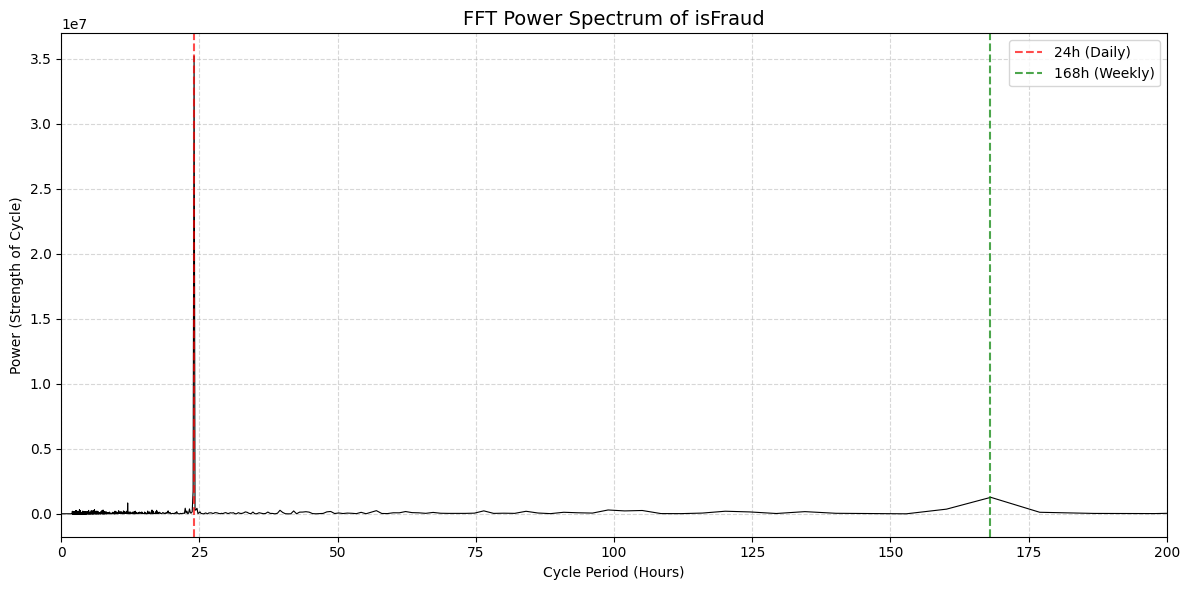

In [12]:
analyze_fft(df)

Biều đồ được cắt đến chu kỳ 200 giờ vì power từ đó trở đi rất mờ nhạt.

`isFraud` được bin theo giờ có "cường độ" của chu kỳ 24h - 1 ngày rất mạnh, ngoài ra còn có một mốc khác đáng chú ý là 168h - 1 tuần. 
    
    Điều này chứng tỏ rằng `isFraud` là một feature phụ thuộc thời gian. Do đó, ta phải chọn time-based spliting strategies khi chia train - validation. 

In [13]:
def create_stats(df: pl.DataFrame, time_col: str, target: str = "isFraud") -> pl.DataFrame:
    """Create temporal statistics with transaction amount."""
    return df.group_by(time_col).agg(
        pl.count().alias("total_transactions"),
        pl.col(target).sum().alias("fraud_count"),
        pl.col(target).mean().alias("fraud_rate"),
        pl.col("TransactionAmt").mean().alias("avg_transaction_amount"),
    ).sort(time_col)

In [14]:
daily_stats = create_stats(df, "day_step")
monthly_stats = create_stats(df, "month_step")

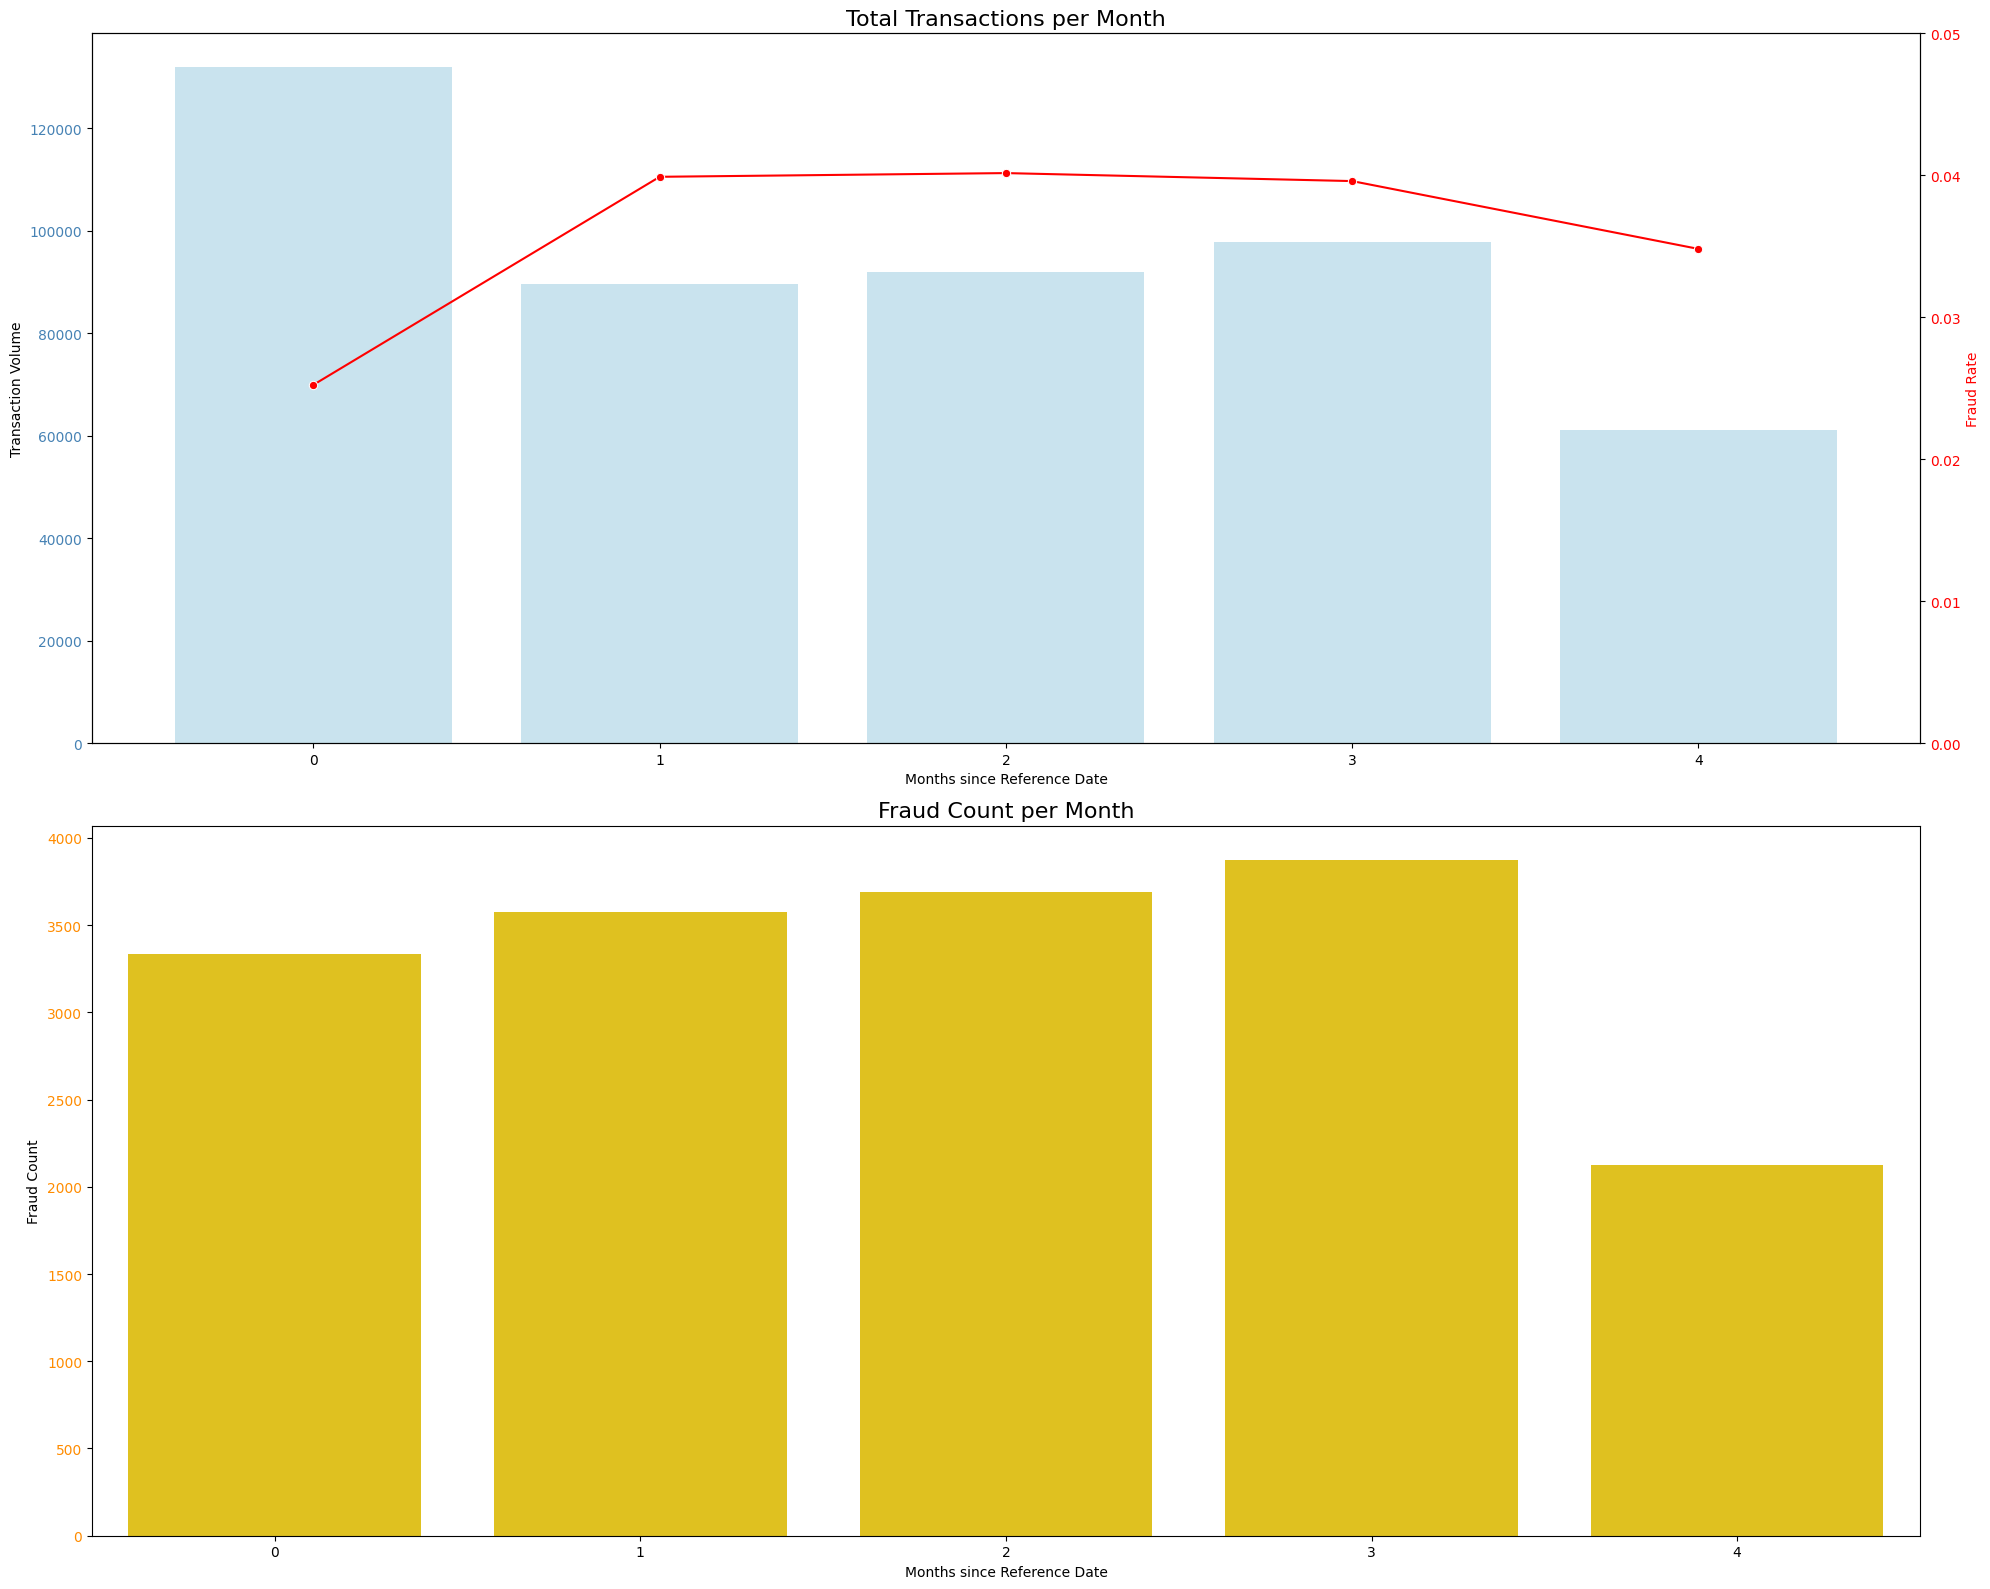

In [15]:
plot_temporal_stats(monthly_stats, x="month_step", tick_interval=1, label="Month", y_lim=0.05)

Vào thời điểm tháng tham chiếu (tháng 0), lượng giao dịch là nhiều nhất (131_974 lượt giao dịch), đồng thời fraud-rate là thấp nhất và dưới mức trung bình (2.5% < 3.5%), với số giao dịch là fraud thấp nhất (3332 giao dịch). 
    
    -> Đây có thể là tháng cao điểm liên quan đến mua sắm (Giáng sinh, Black Friday, etc.) khi mà lượng giao dịch thật mua sắm nhiều hơn bình thường trong khi lực lượng thực hiện giao dịch gian lận vẫn hoạt động như mọi khi dẫn đến việc ảnh hưởng của giao dịch gian lận có phần bị lu mờ (hiện tượng dilution effect).

Sang tháng tham chiếu 1, lượng giao dịch giảm mạnh xuống còn 90_000 và fraud rate tăng mạnh lên mức gần 4% (tăng ~1%) cho thấy regime shift sau tháng tham chiếu 0, trong khi đó lượng giao dịch gian lận tăng lên khoảng 250 lượt so với tháng 1.

    -> Việc tăng mạnh fraud rate thực chất là do dulation effect từ tháng 0, đồng thời cũng do tăng về lượng giao dịch gian lận trong tháng 1.

Sau đó, lượng thực hiện giao dịch gian lận tiếp tục tăng kể cho đến tháng 3 (3332->3875 lượt), tuy nhiên fraud rate lại có xu hướng giảm nhẹ trong giai đoạn này. Trong khi đó, lượng giao dịch có xu hướng tăng từ 89_000 đến khoảng 98_000 lượt. Đây là giai đoạn dữ liệu ổn định nhất.

    -> Điều này gợi ý có thể lượng giao dịch gian lận có thể tăng cùng nhịp với lượng giao dịch trong giai đoạn này.

Đến tháng 4, ta thấy sự sụt giảm đột ngột và bất thường trên mọi chỉ số khi mà lượng giao dịch tụt xuống đáy (61_063), số vụ gian lận giảm gần một nửa (2126), và Fraud Rate cắm đầu đi xuống.

    -> Hiện tượng này có thể không đúng sự thật bởi do tháng này là tháng khuyết khoảng 10 ngày (như đã được phát hiện ở trên). Nếu thực hiện time-based split theo tháng, cần phải cân nhắc loại bỏ tháng 4 vì yếu tố nhiễu.


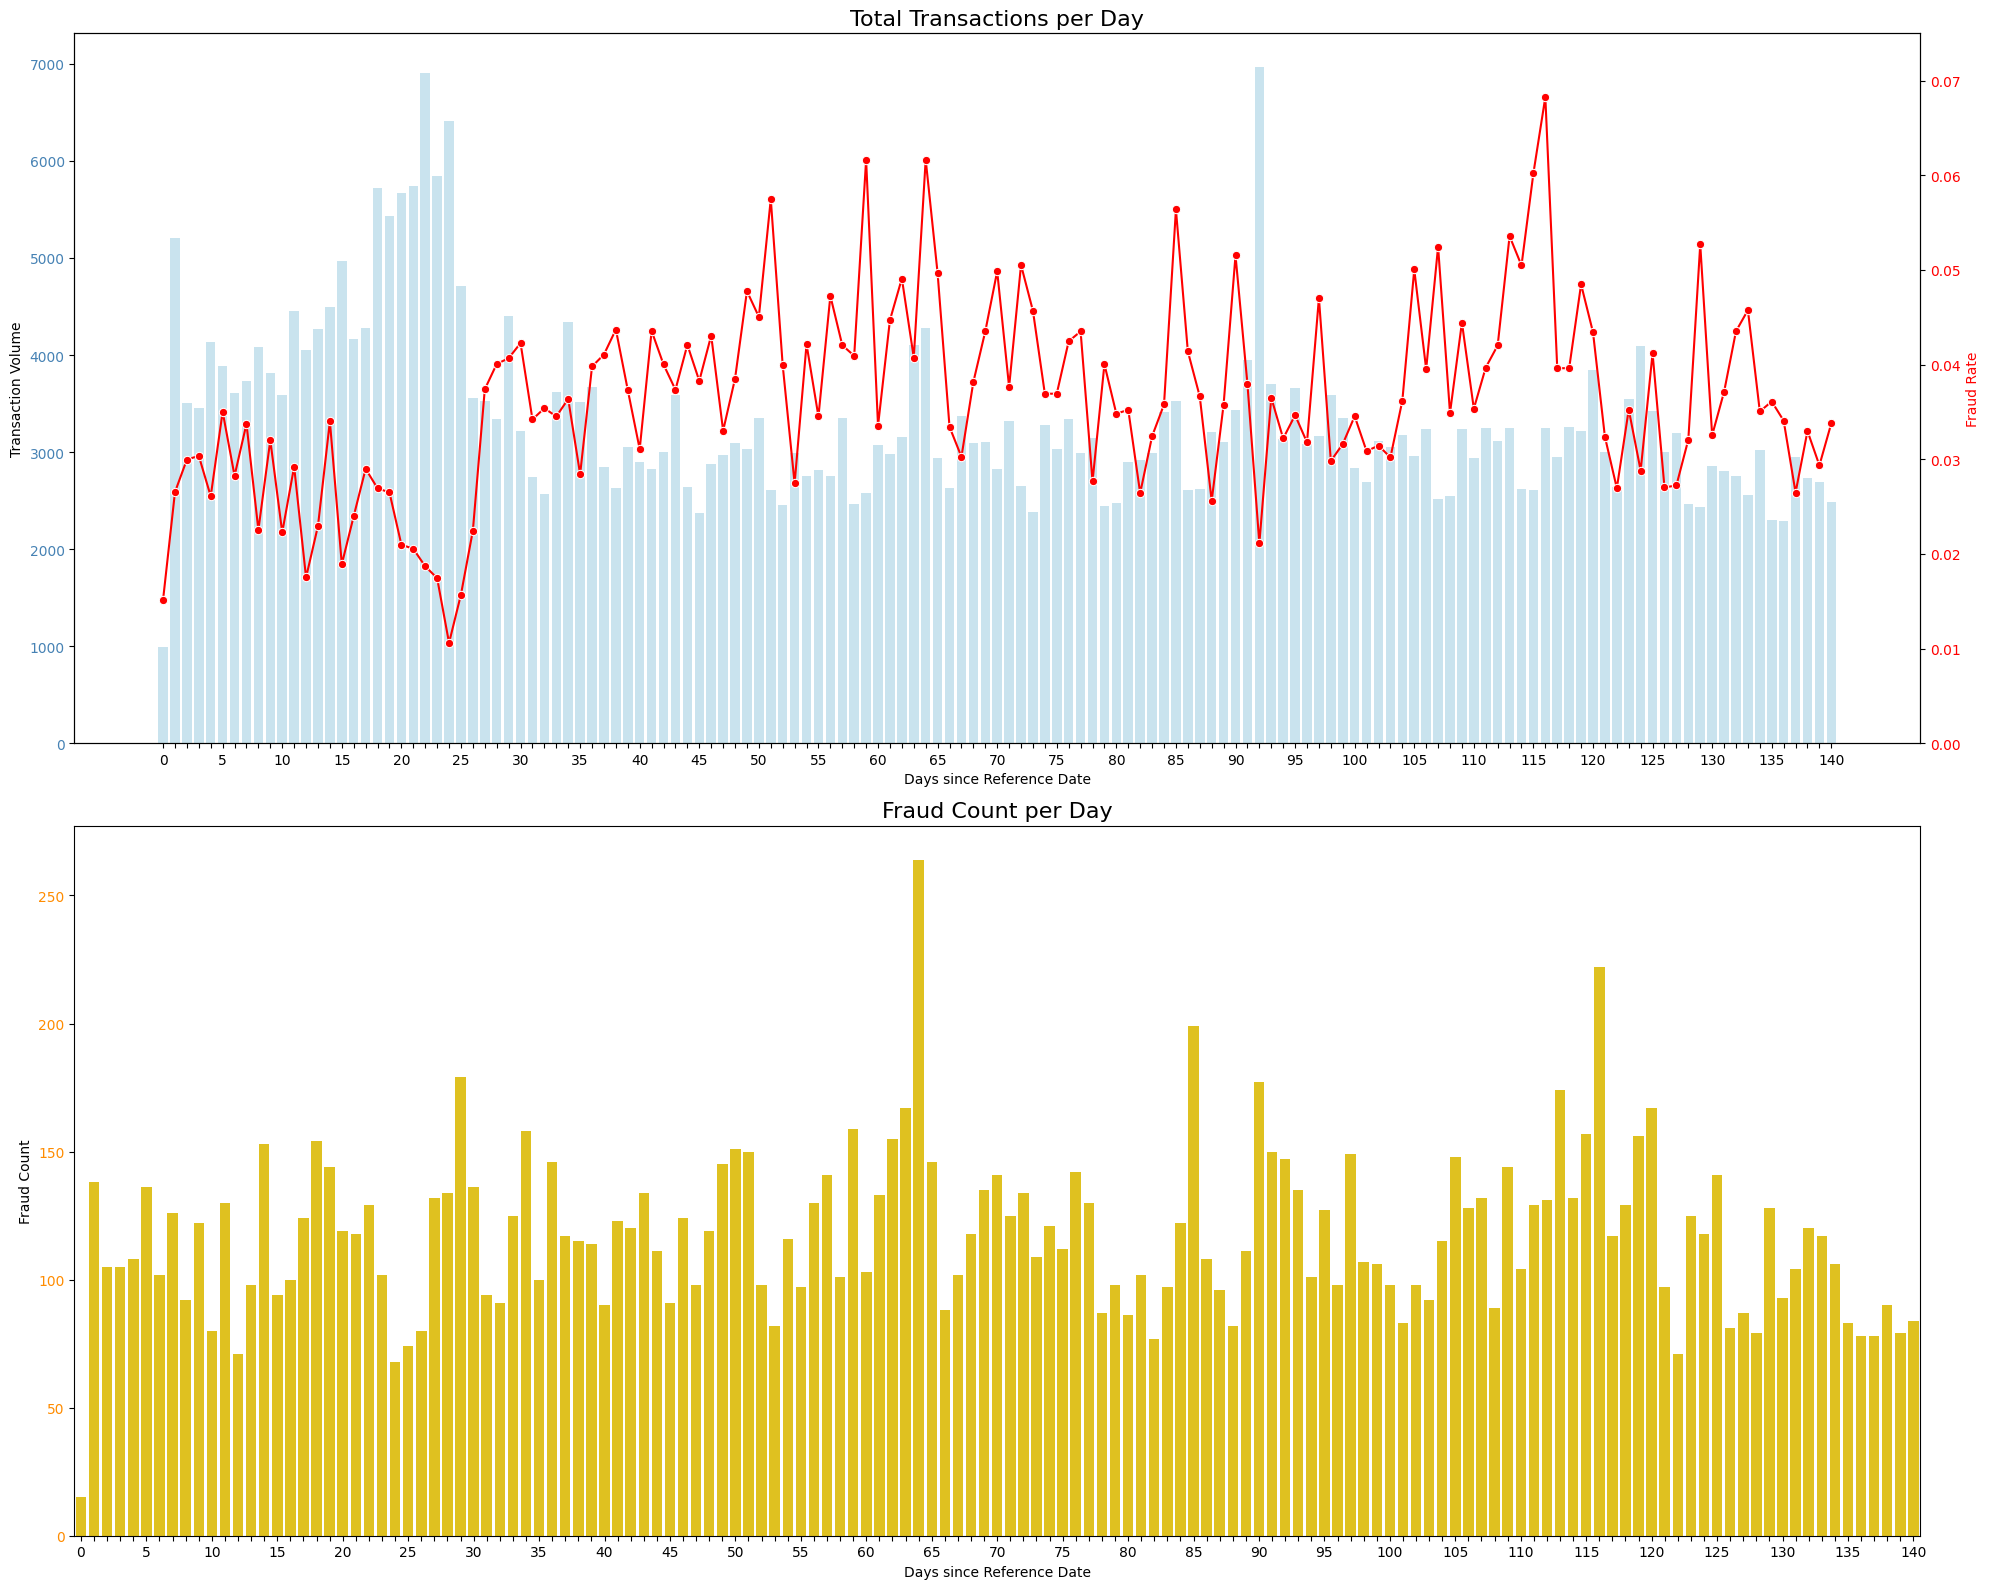

In [16]:
plot_temporal_stats(daily_stats, x="day_step", tick_interval=5, label="Day", y_lim=0.075)

Từ ngày 0->25, lượng giao dịch có xu hướng tăng và chạm đỉnh tại ngày 22 (~6_900 records), sau đó đến ngày 25 thì bình ổn lại. Với lượng giao dịch gian lận thì nhìn chung tương đối ổn định.

    Khoảng thời gian này có thể là những sự kiện lớn trong năm của người Mỹ như Giáng sinh, gây ra mức tăng mạnh tạm thời về lượng giao dịch trong 1 tháng.

Vào ngày 64, số lượng giao dịch gian lận được ghi nhận tăng đột ngột từ khoảng 160 -> 260 records. 

Vào ngày 92 có sự tăng đột ngột về lượng giao dịch thực hiện, tuy nhiên lượng giao dịch gian lận không tăng tương ứng. 
    
    Ngày này có thể là một ngày đặc biệt trong mua sắm như Black Friday.

Ngày 116 là ngày có fraud rate cao nhất trong tập dữ liệu trong khi lượng giao dịch không thay đổi nhiều so với các ngày trước.

    Cần quan tâm ngày 64 và 116, đây có thể là các đợt tấn công.

## 01.03 - Card features

In [17]:
card_cols = sorted([col for col in df.columns if col.startswith("card")])
card_cols

['card1', 'card2', 'card3', 'card4', 'card5', 'card6']

In [18]:
card_df = df.select(card_cols + [target, "ProductCD"])
print(card_df.glimpse())
print(card_df.describe())
print(card_df.select(pl.all().n_unique()))

Rows: 472432
Columns: 8
$ card1     <i32> 13926, 2755, 4663, 18132, 4497, 5937, 12308, 12695, 2803, 17399
$ card2     <f32> null, 404.0, 490.0, 567.0, 514.0, 555.0, 360.0, 490.0, 100.0, 111.0
$ card3     <f32> 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0, 150.0
$ card4     <cat> discover, mastercard, visa, mastercard, mastercard, visa, visa, visa, visa, mastercard
$ card5     <f32> 142.0, 102.0, 166.0, 117.0, 102.0, 226.0, 166.0, 226.0, 226.0, 224.0
$ card6     <cat> credit, credit, debit, debit, credit, debit, debit, debit, debit, debit
$ isFraud   <i32> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
$ ProductCD <cat> W, W, W, W, H, W, W, W, H, W

None
shape: (9, 9)
┌───────────┬───────────┬───────────┬───────────┬────────┬──────────┬────────┬──────────┬──────────┐
│ statistic ┆ card1     ┆ card2     ┆ card3     ┆ card4  ┆ card5    ┆ card6  ┆ isFraud  ┆ ProductC │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆ ---    ┆ ---      ┆ ---    ┆ ---      ┆ D        │
│ str       ┆ f64     

`card1` và `ProductCD` là trường thẻ duy nhất có thông tin đầy đủ, không có missing values. Về phía `card1` có khả năng là một loại trường (từ 4-5 chữ số) bắt buộc không giao dịch nào được phép thiếu. 

Theo sau là `card3`, `card4` (card scheme), và `card6` (card type) với missing values khoảng 830 records.

### **Univariate Analysis**

#### Card4 - Card schema

In [19]:
common_day_args = {
    "df": df,
    "time_col": "day_step",
    "tick_interval": 15,
    "log_scale": False,  
    "show_volume": True
}

common_month_args = {
    "df": df,
    "time_col": "month_step",
    "tick_interval": 1,
}

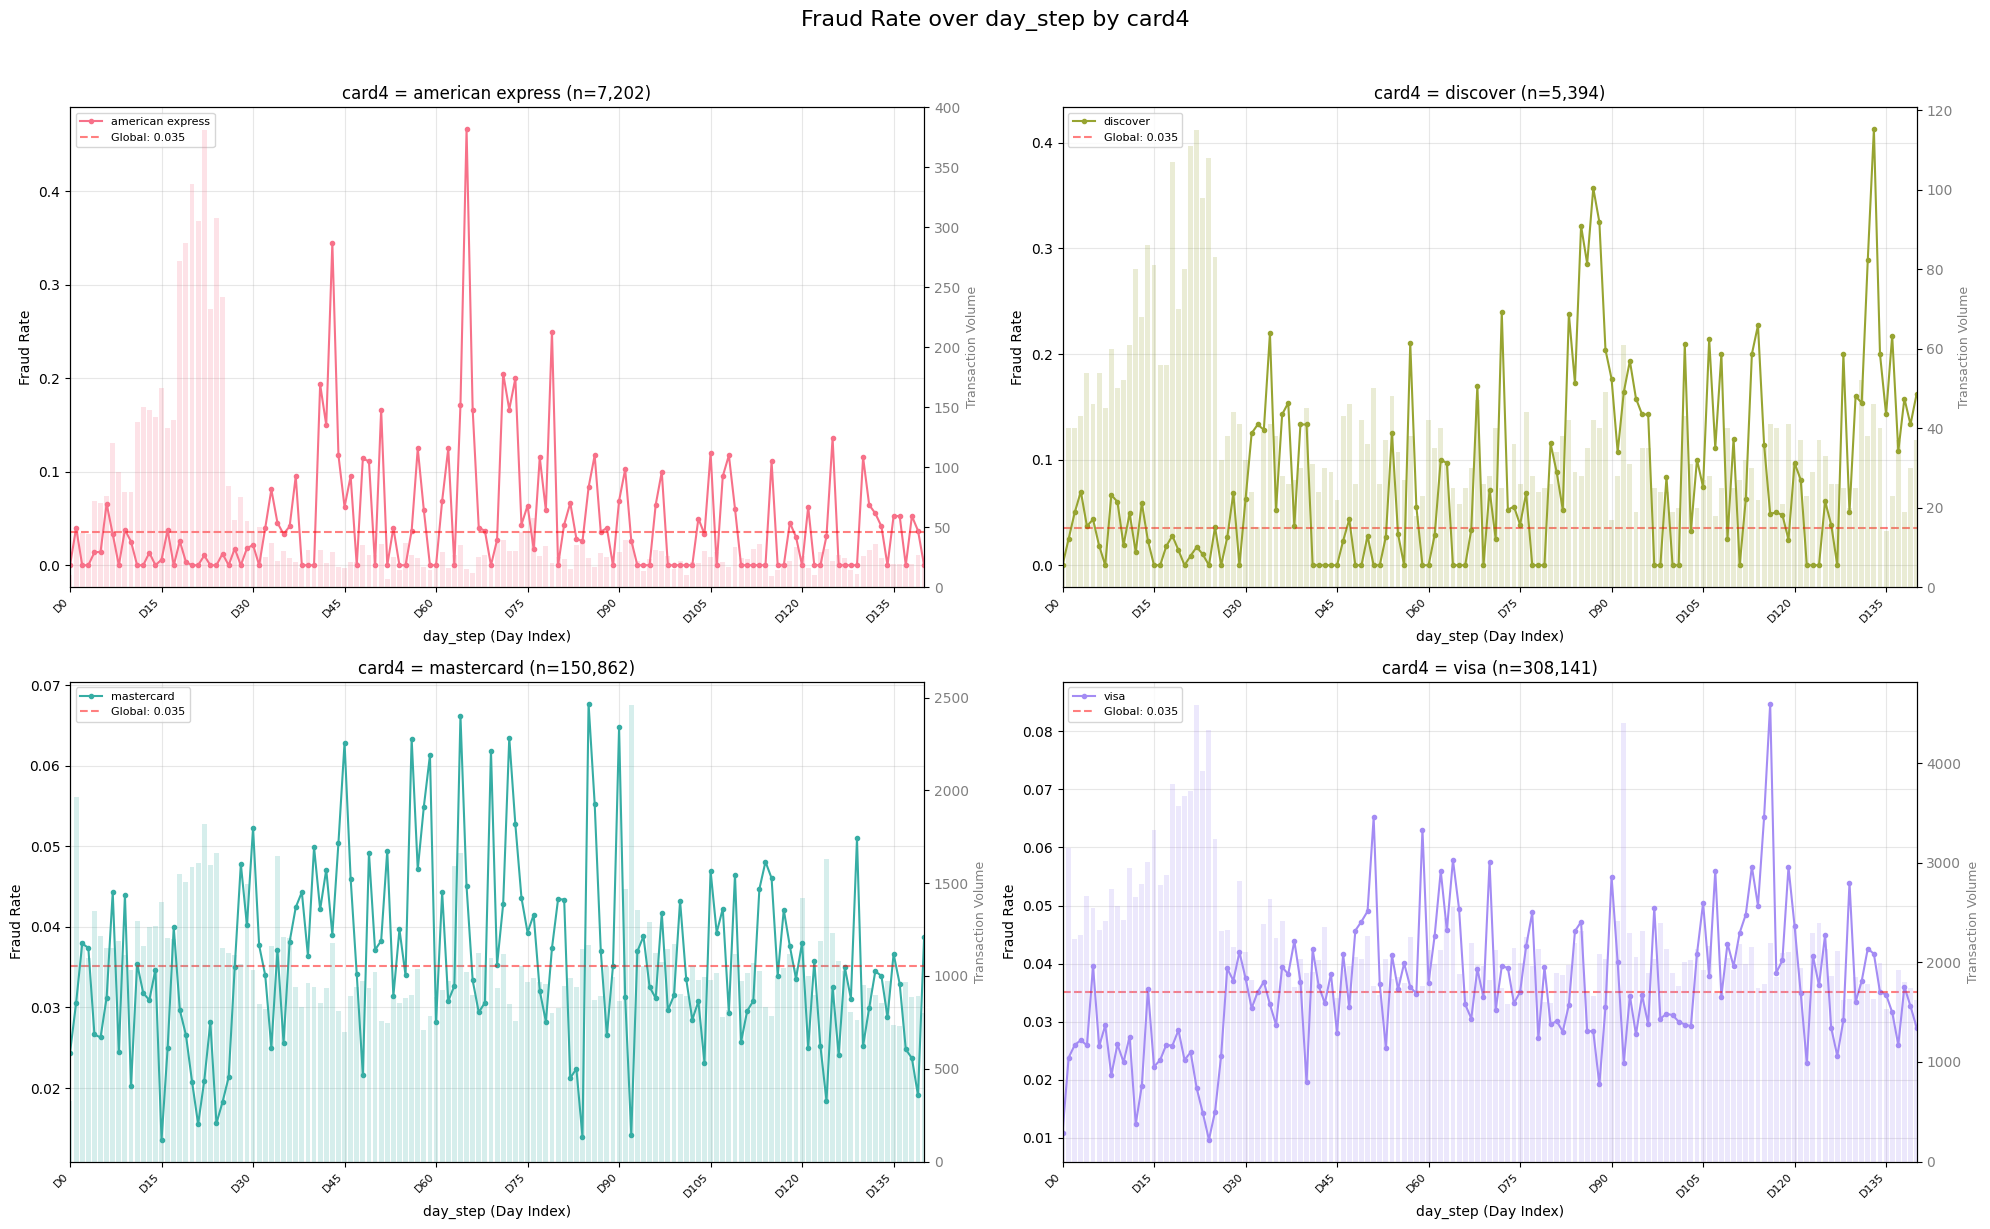

In [20]:
plot_temporal_by_category( **common_day_args, category_col="card4" )

Nhìn chung, các loại thẻ đều có chung một khoảng thời gian mà khi đó lượng giao dịch tăng rất nhiều là tầm ngày 25-30 của tháng tham chiếu đầu tiên.

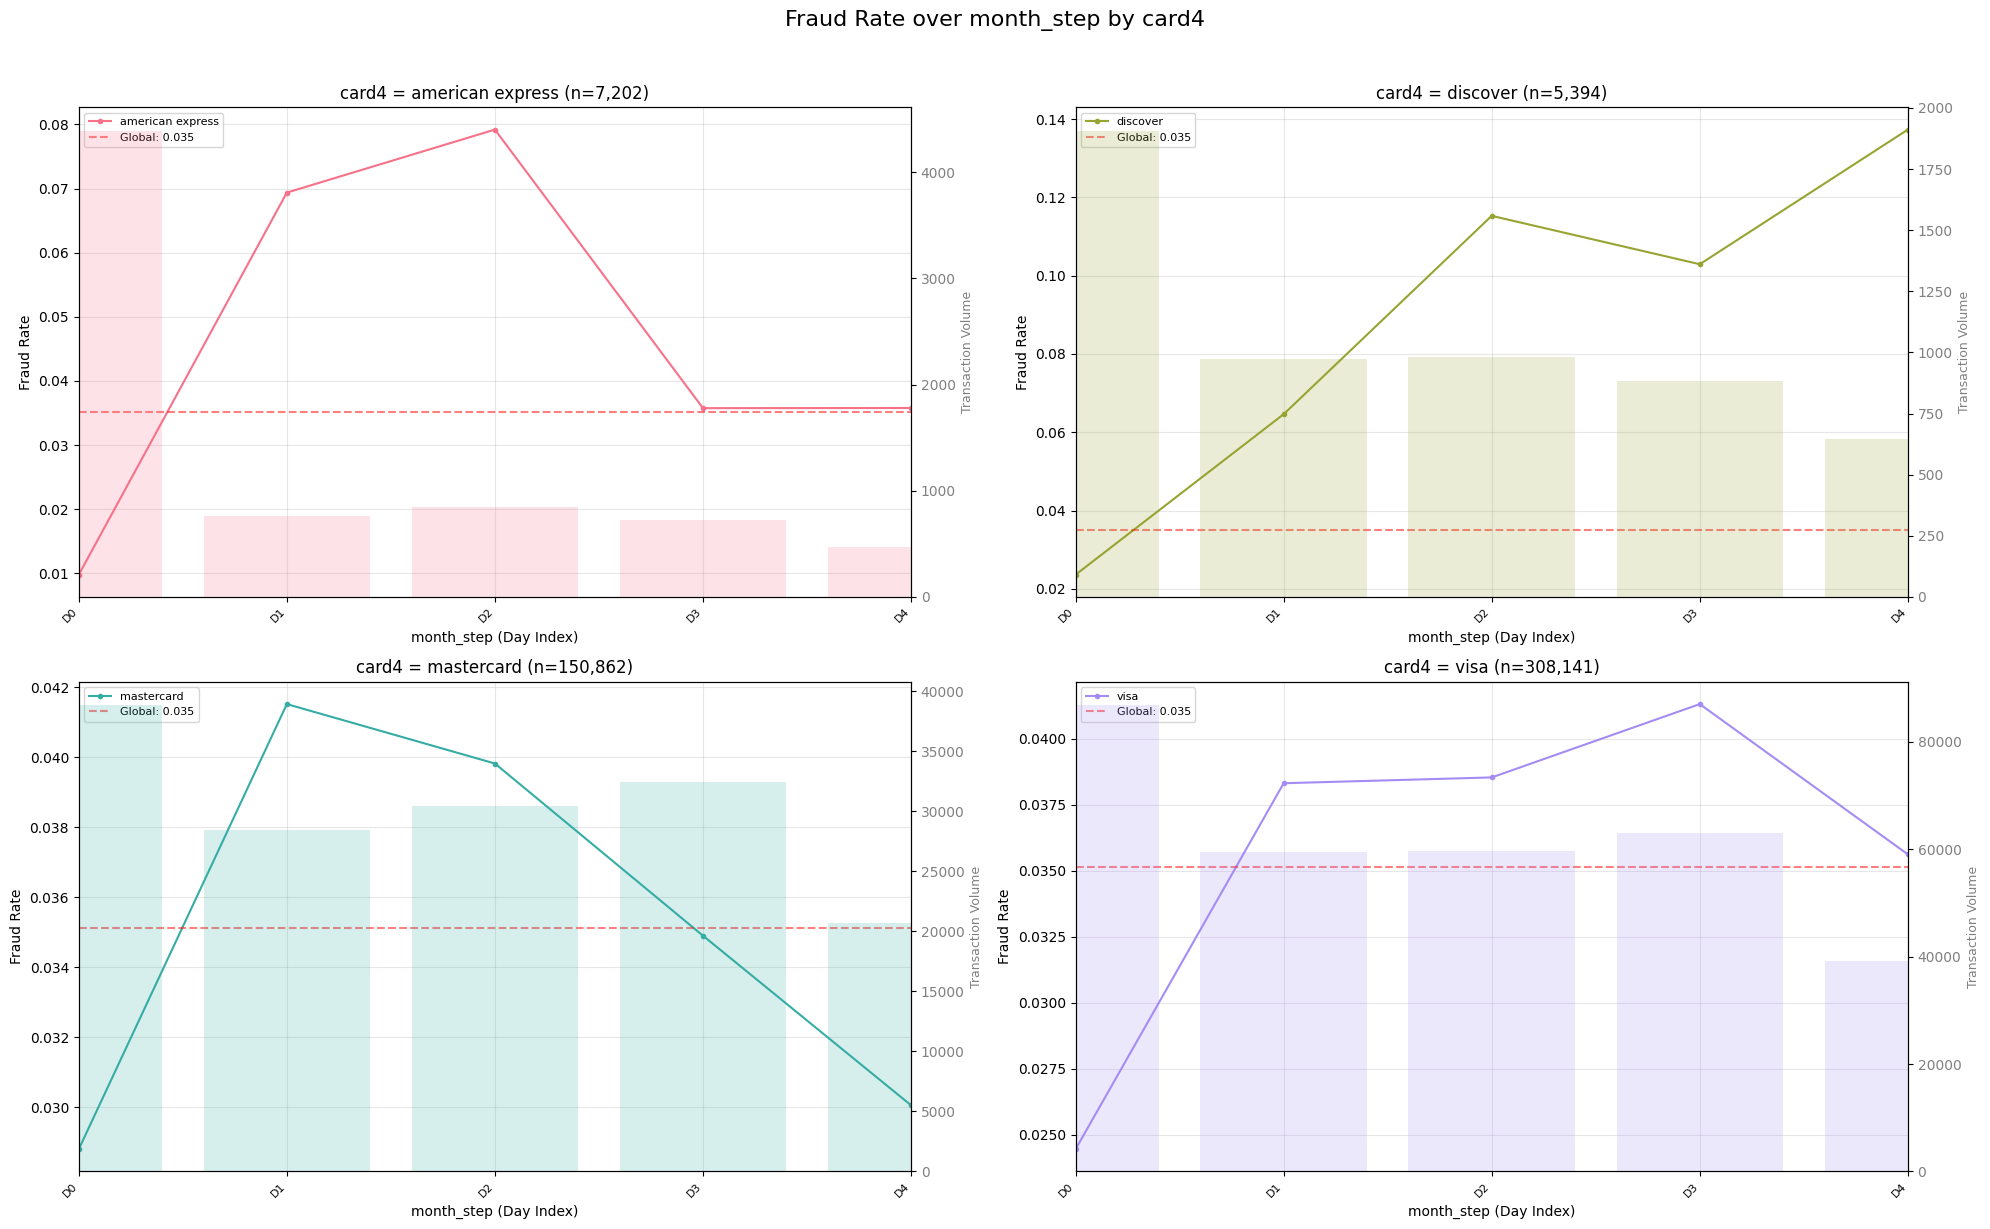

In [39]:
plot_temporal_by_category( **common_month_args, category_col="card4" )

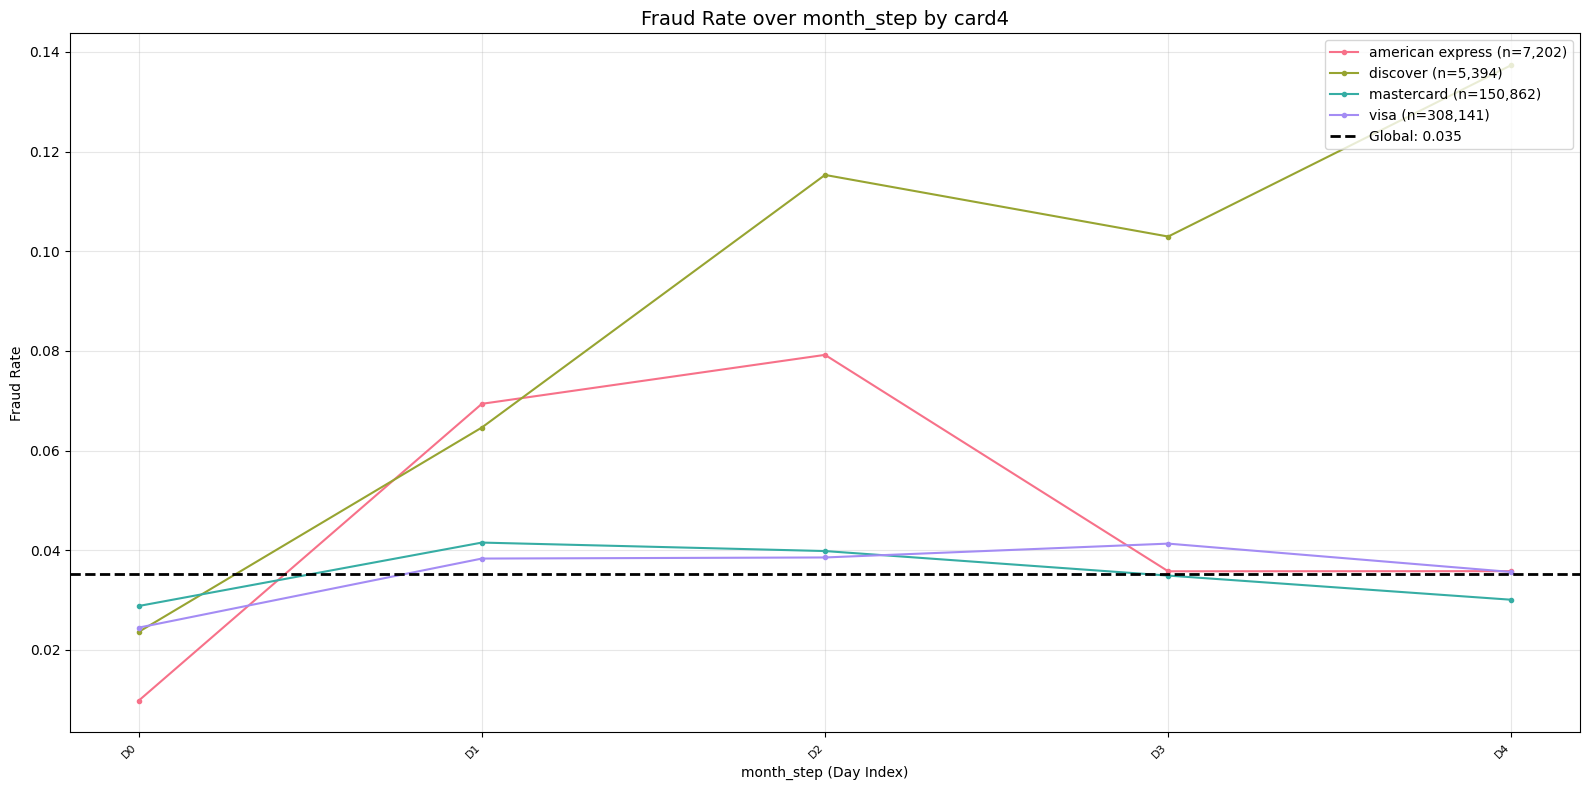

In [41]:
plot_temporal_overlay( **common_month_args, category_col="card4" )

#### Card6 - Card type 

In [45]:
df["card6"].unique()

card6
cat
null
"""credit"""
"""debit"""
"""debit or credit"""
"""charge card"""


Theo MoMo và American Express:

`Thẻ tín dụng (Credit card):` 

- Thẻ ngân hàng cho phép tiêu trước, trả sau và đến kỳ hạn trả phải trả tối thiểu trên hạn mức. (Trả góp)

- Nguồn tiền: gồm tiền ngân hàng cho phép vay tạm thời và tiền của chủ sở hữu thẻ.

- Hạn mức: được định sẵn.

- Ảnh hưởng đến xếp hạng tín dụng.

`Thẻ ghi nợ (Debit card):` 

- Là thẻ ngân hàng cho phép bạn dùng trên số dư, hạn mức thường được giới hạn bởi số dư.

- Nguồn tiền: tiền của chủ sở hữu thẻ.

- Không ảnh hưởng đến xếp hạng tín dụng.


`Thẻ thanh toán (Charge card):` 

- Giống credit card, khác ở chỗ là đến kỳ hạn phải trả hết số nợ. (Trả nguyên cục)

- Hạn mức: dạng 'no-preset limit', dựa trên mức độ uy tín và hành vi của chủ thẻ.

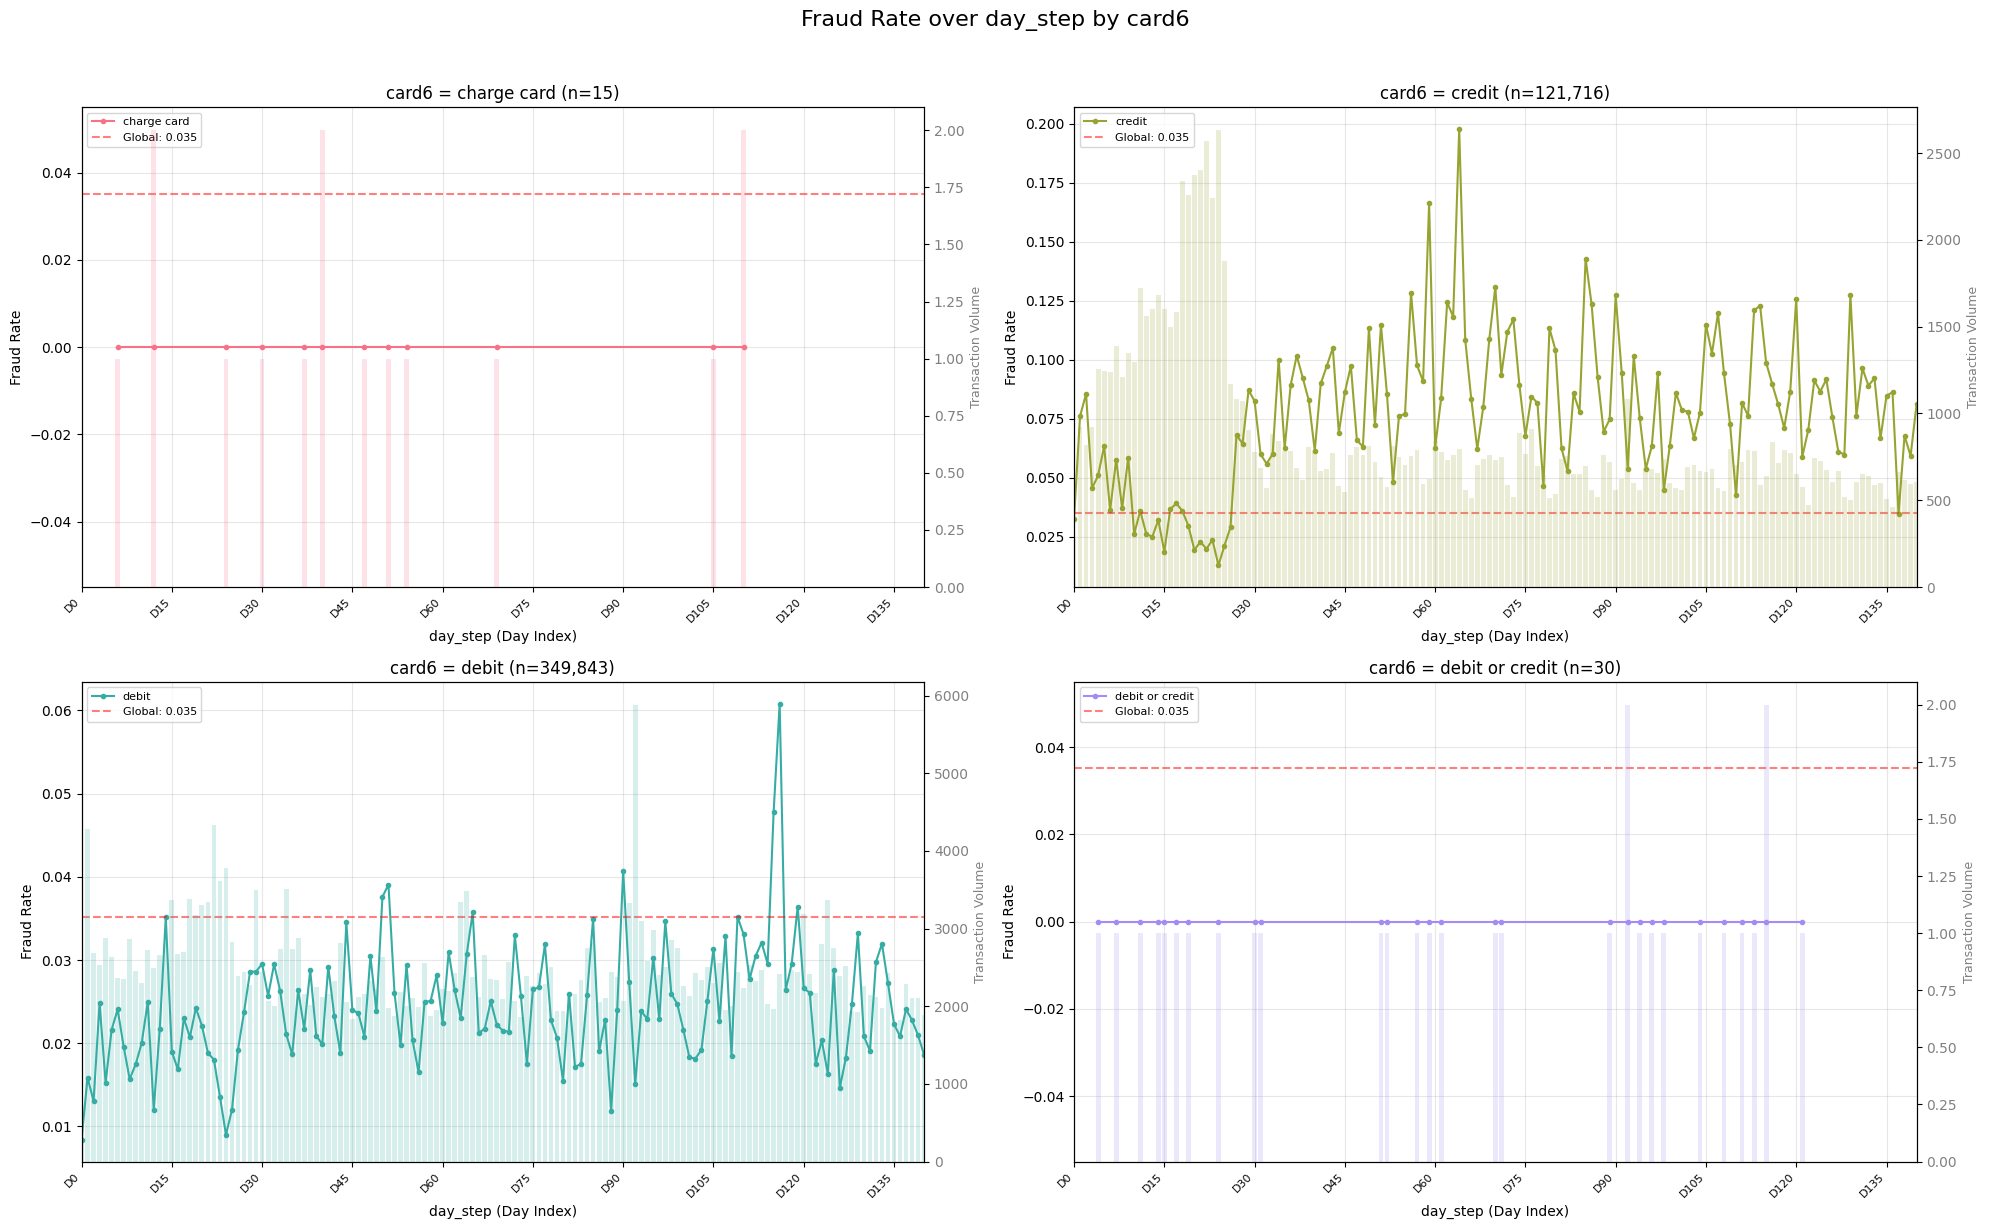

In [46]:
plot_temporal_by_category( **common_day_args, category_col="card6" )

#### ProductCD - Product Code

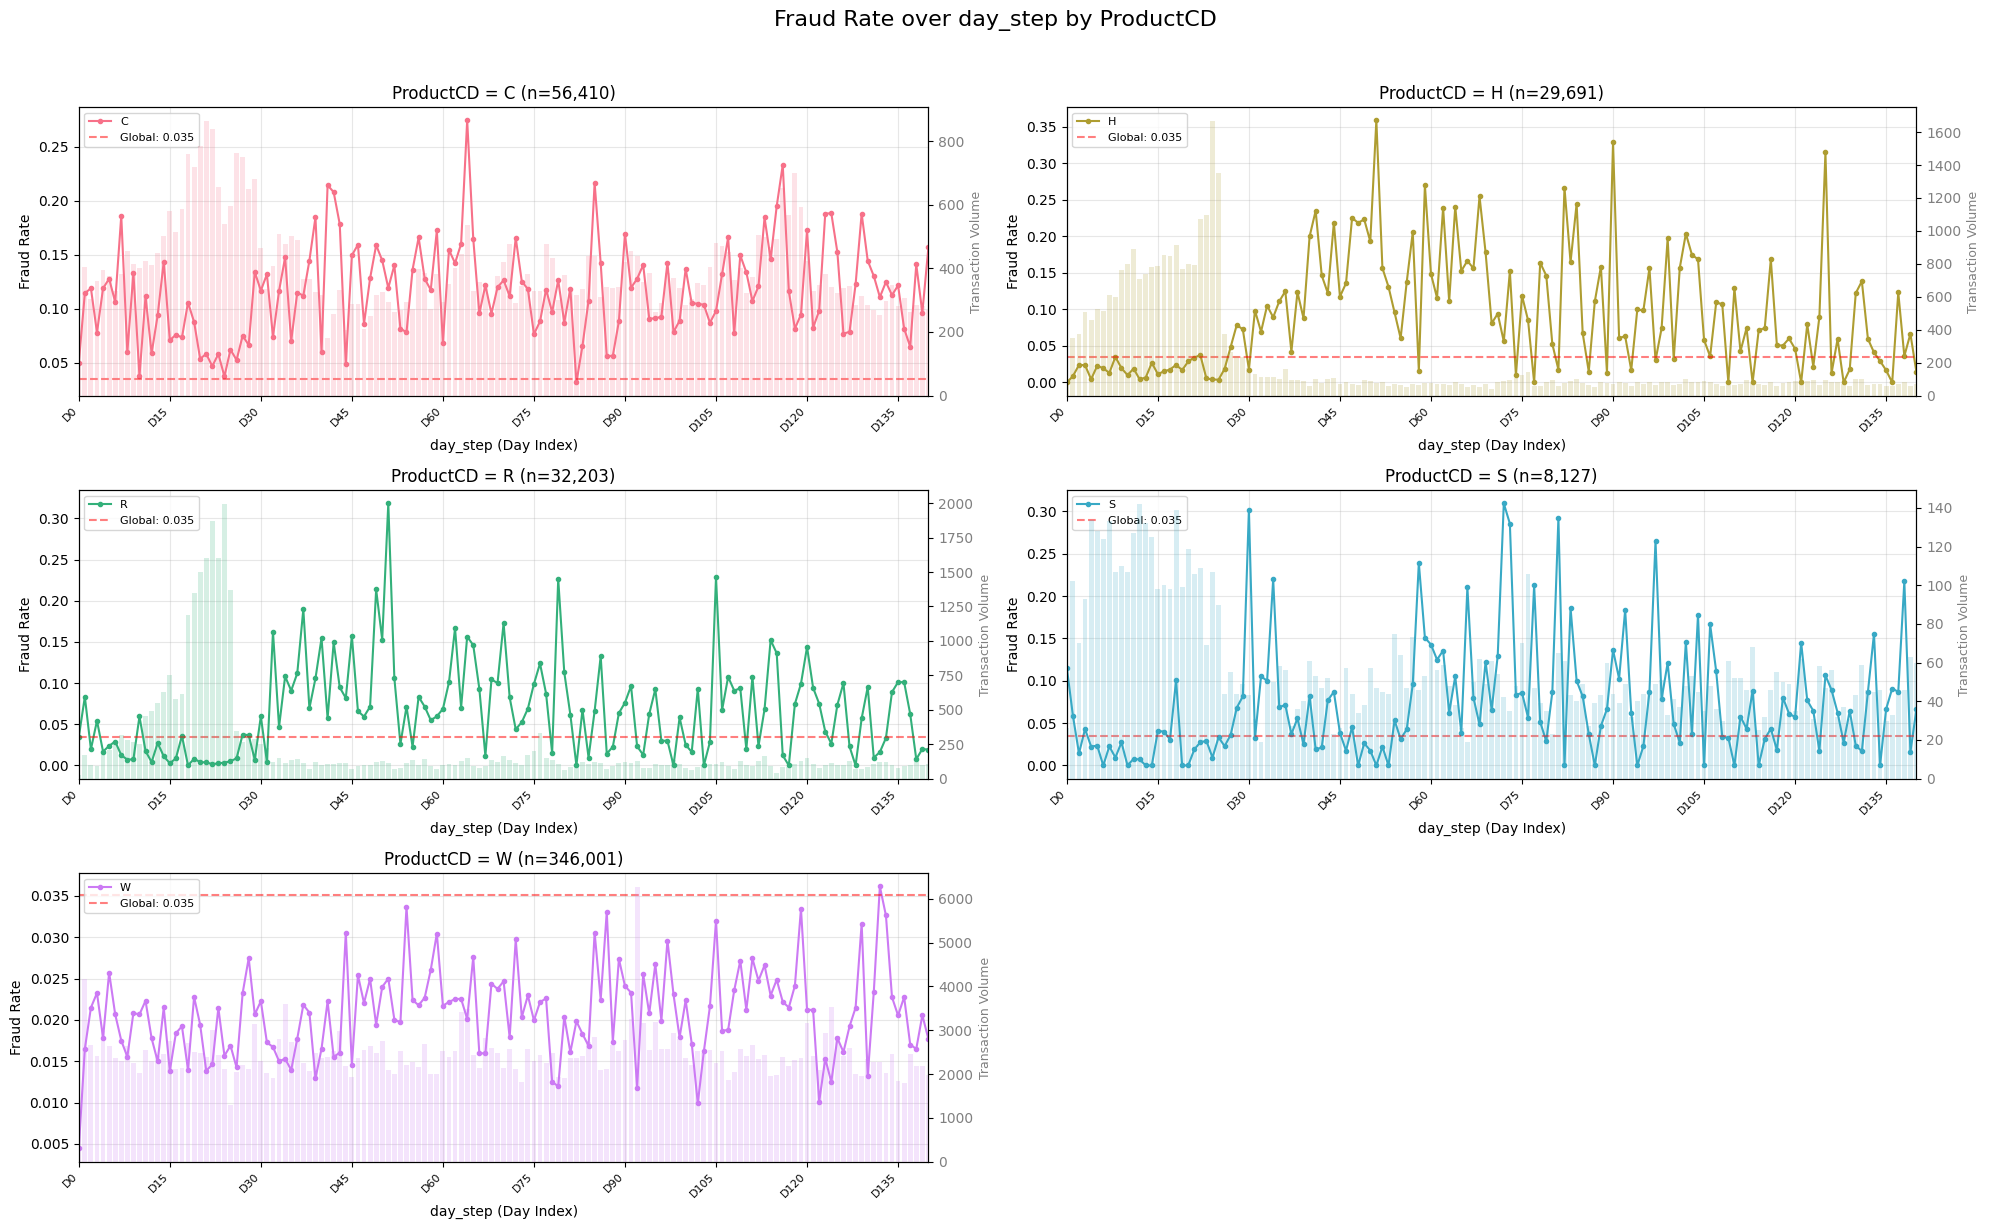

In [23]:
plot_temporal_by_category( **common_day_args, category_col="ProductCD" )

### **Multivariate Analysis**

#### Card6 (Card schema) x Card4 (Card type) x isFraud

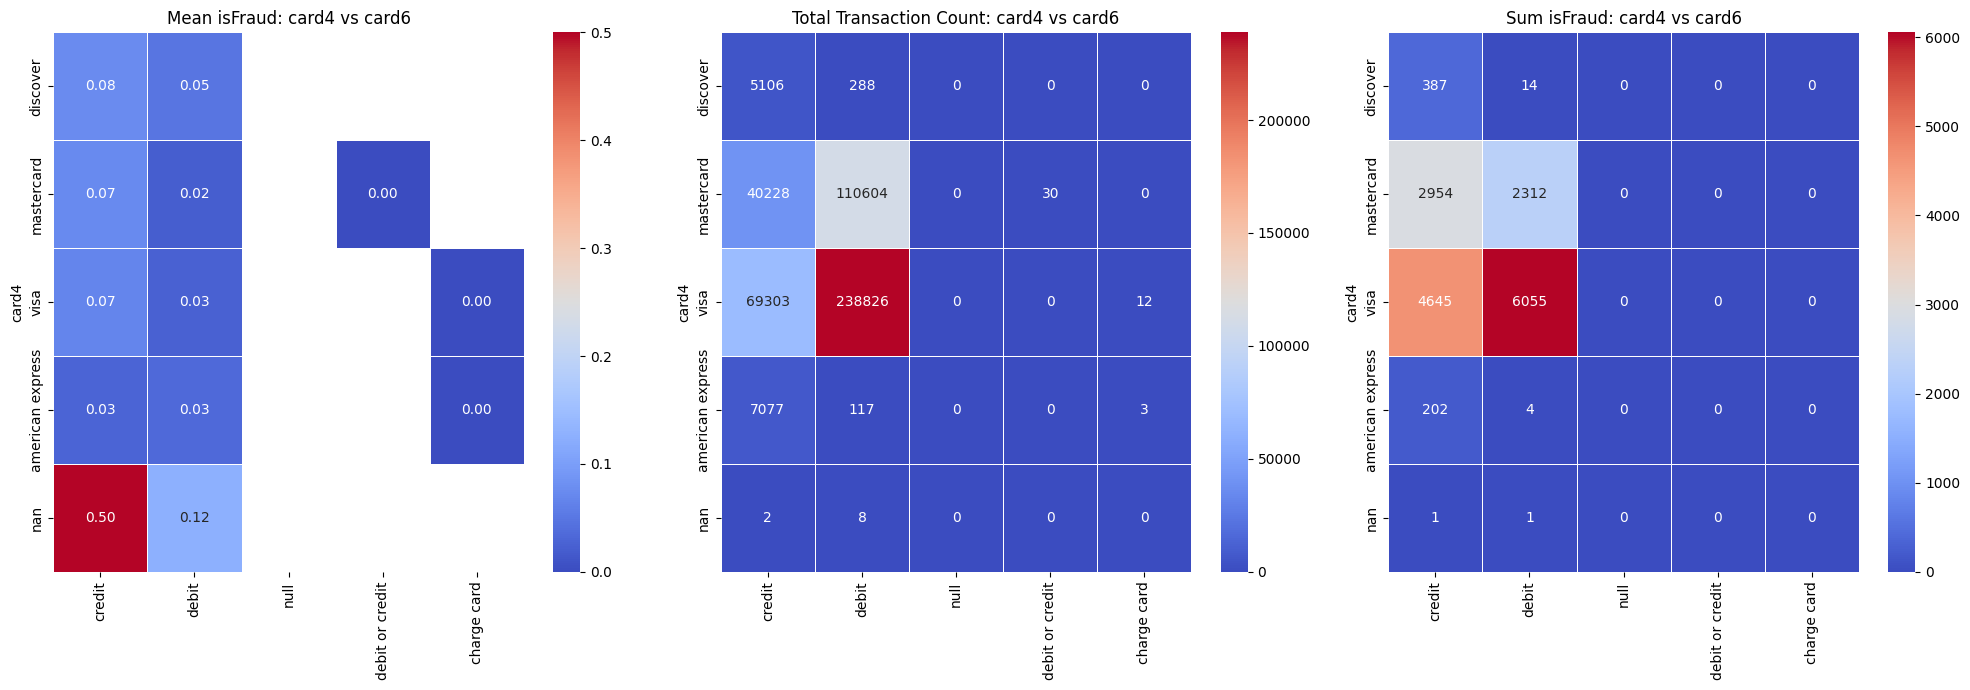

In [24]:
plot_heatmap_info(df, on="card6", index="card4", values="isFraud")

Nhìn chung, credit card có rủi ro cao hơn so với debit card, đặc biệt là trong 3 card schema là discorver, mastercard, visa. Về phía american express thì debit có phần nhỉnh hơn.

Debit có lượng giao dịch lớn nhất, đồng thời cũng có nhiều records về giao dịch gian lận nhất.

Loại thẻ 'debit or card' và 'charge card' không có ý nghĩa thống kê vì tập dữ liệu quá ít và không đa dạng; dẫn đến phản ánh sai thực tế.

    - Hai loại values này sẽ được gộp lại vào nhóm credit card.

    - Sự kết hợp giữa card4 và card6 có ý nghĩa và nên cân nhắc gom nhóm hai features này.

#### Card4 (Card type) x ProductCD x isFraud

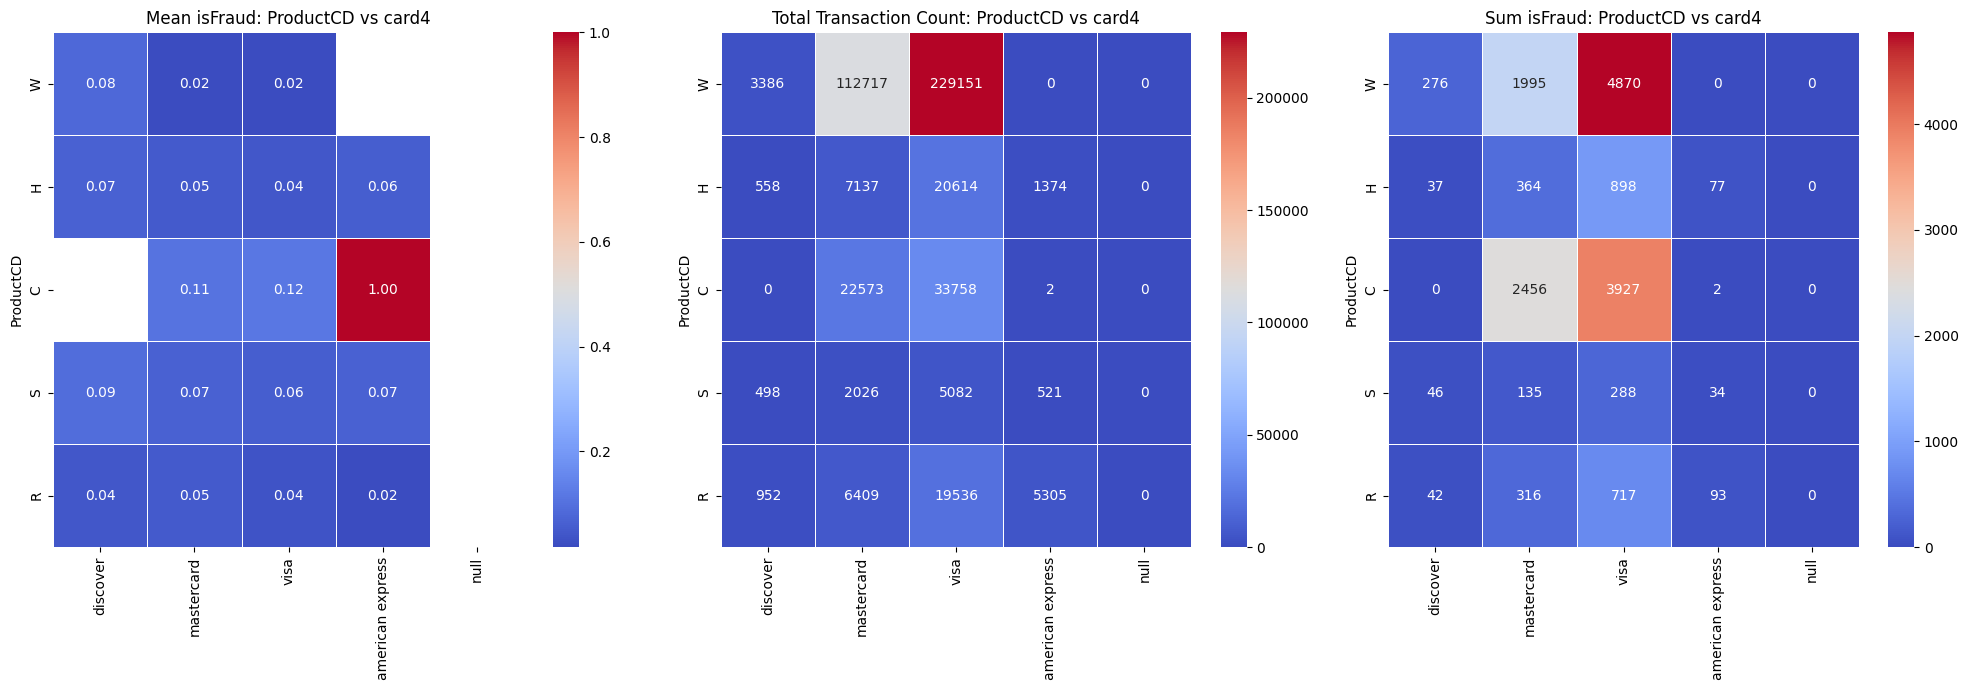

In [26]:
plot_heatmap_info(df, on="card4", index="ProductCD", values="isFraud")

#### Card6 (Card type) x ProductCD x isFraud

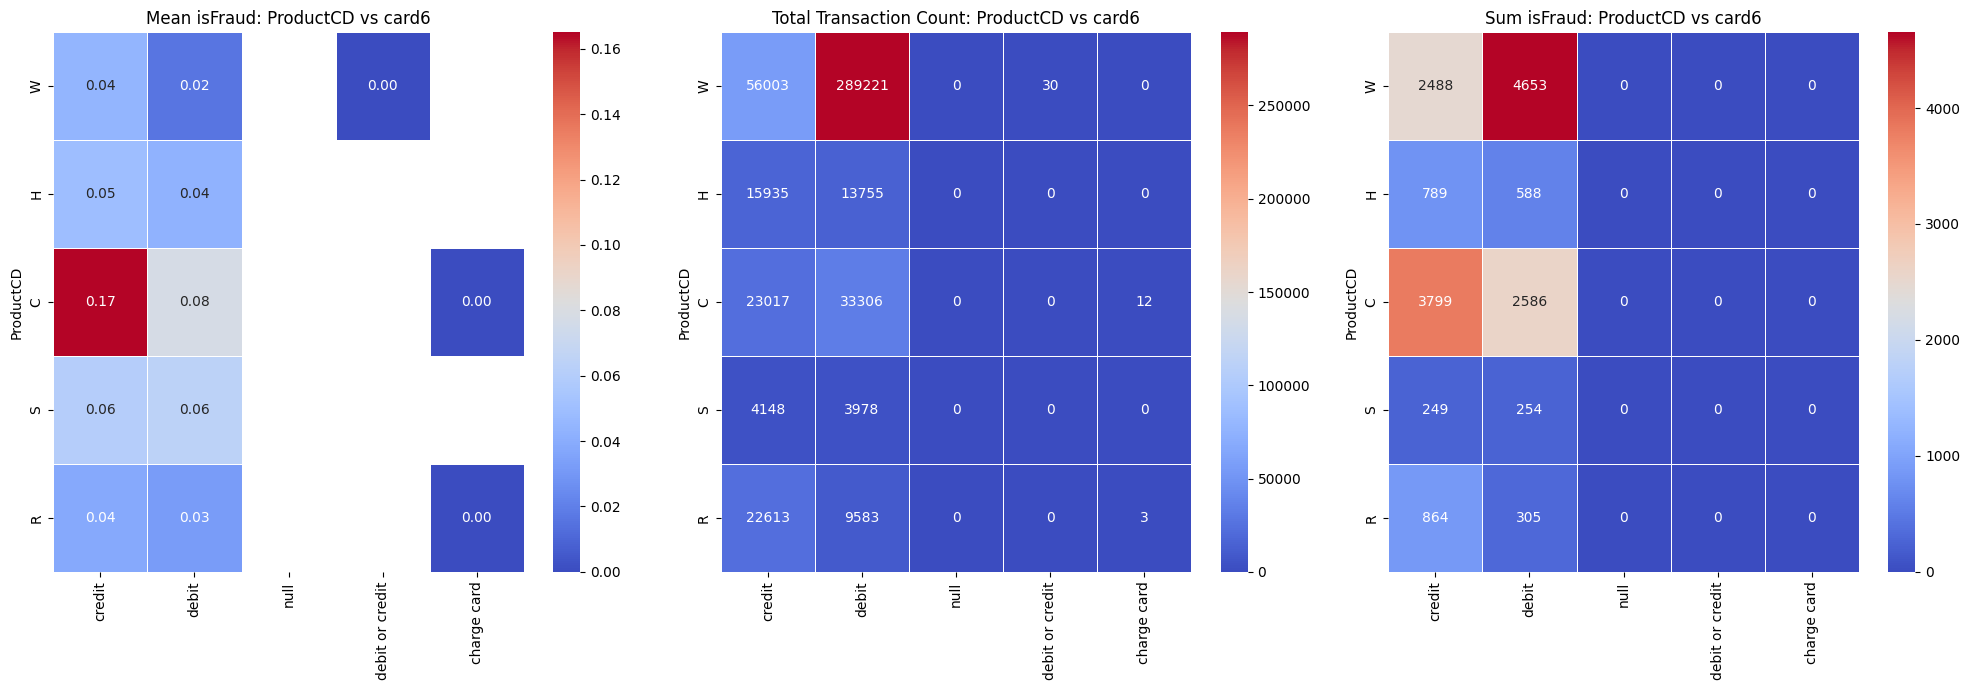

In [27]:
plot_heatmap_info(df, on="card6", index="ProductCD", values="isFraud")

# Miscellaneous

In [28]:
df["has_identity"].value_counts()

has_identity,count
u8,u32
1,120464
0,351968


In [29]:
df["has_identity", target].group_by(target).mean()

isFraud,has_identity
i32,f64
1,0.548166
0,0.244311


Một phát hiện khác so với kỳ vọng ban đầu là fraudulent transaction sẽ bị thiếu thông tin identity, trong khi non-fraud thì ngược lại.

Trở lại ván cờ thực tế, fraudulent transaction có xu hướng thêm thông tin identity nhiều hơn (54.8% có identity), trong khi đó non-fraudulent lại thiên về hướng không có thông tin identity (75.5% có identity).



In [31]:
feats = {
    "v": [col for col in df.columns if col.startswith('V')],
    "id": [col for col in df.columns if col.startswith('id')],
    "m": [col for col in df.columns if col.startswith('M')],
    "card": [col for col in df.columns if col.startswith('card')],
    "addr": [col for col in df.columns if col.startswith('addr')],
    "dist": [col for col in df.columns if col.startswith('dist')],
    "c": [col for col in df.columns if col.startswith('C')],
    "d": [col for col in df.columns if col.startswith('D')],
    "transaction": [col for col in df.columns if col.startswith('Transaction')],
    "device": [col for col in df.columns if col.startswith('Device')],
}

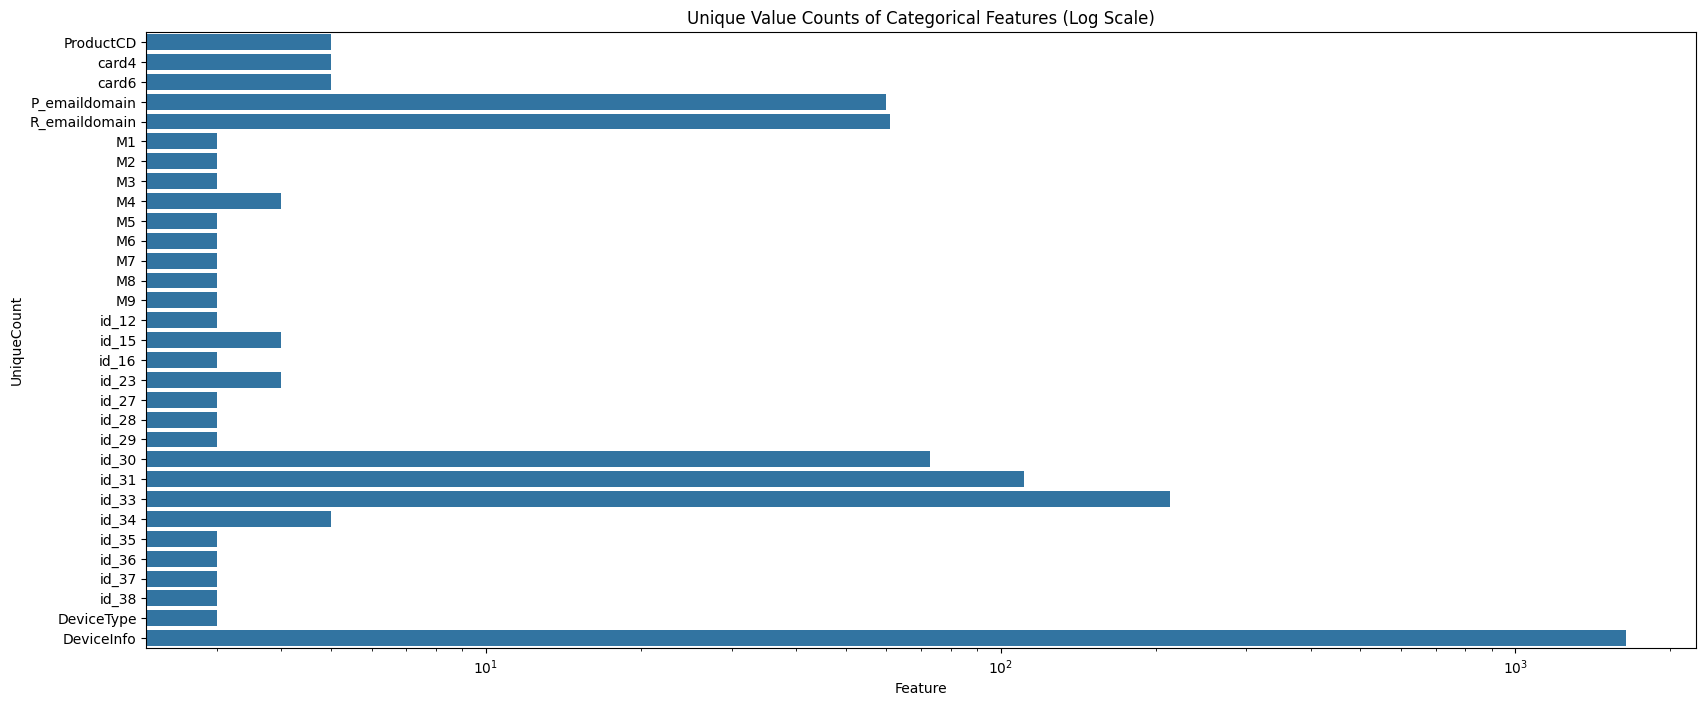

DeviceInfo      (n=1640) [None, 'SAMSUNG SM-G892A Build/NRD90M', 'iOS Device', 'Windows', 'MacOS', 'SM-G930V Build/NRD90M', 'BLADE A602 Build/MRA58K', 'XT1635-02 Build/NPN26.118-22-2', 'Z970', 'SM-N920V Build/NRD90M', 'Redmi Note 4 Build/MMB29M', 'Lenovo PB1-750M Build/S100', 'LT22i Build/6.2.A.1.100', 'rv:52.0', 'SM-G950U Build/NRD90M', 'LG-H872 Build/NRD90U', 'LG-K500 Build/MMB29M', 'SM-P550 Build/MMB29M', 'SM-J700M Build/MMB29K', 'Trident/7.0', 'rv:57.0', 'SAMSUNG SM-G930T Build/NRD90M', 'Blade V6 Plus Build/MRA58K', 'BLL-L23 Build/HUAWEIBLL-L23', 'KYOCERA-C6742A Build/LMY47V', 'F3113 Build/33.2.A.4.70', 'D5306 Build/19.4.A.0.182', 'M4 SS4457 Build/MRA58K', 'SM-G955U Build/NRD90M', 'SM-G610M Build/MMB29K', 'SAMSUNG SM-G935F Build/NRD90M', 'XT1635-01', 'rv:56.0', 'VS500', 'CAM-L03 Build/HUAWEICAM-L03', 'RCT6303W87M7 Build/MRA58K', 'M4 SS4451 Build/LMY47D', 'KFFOWI Build/LVY48F', 'Moto E (4) Build/NMA26.42-19', 'SAMSUNG', 'E2306 Build/26.3.A.1.33', 'Ilium L910 Build/MRA58K', 'GT-I9300

In [32]:
unique_df = df.select(cs.categorical().n_unique()).unpivot(variable_name='Feature', value_name='UniqueCount')
ax = sns.barplot(data=unique_df, x='Feature', y='UniqueCount')
ax.figure.set_size_inches(20, 8)
ax.set_xscale('log')
ax.set_title('Unique Value Counts of Categorical Features (Log Scale)')
plt.show()
for col in cat_cols:
    nunique = df[col].unique().to_list()
    print(f"{col:<15} (n={len(nunique)}) {nunique}")

***Nhìn chung***

- Hầu hết features có unique values nhỏ < 5 values, có 6 features có tương đối nhiều unique value như:
    `DeviceInfo (n=1648)`
    
    `id_33 (n=213) {logical resolution}`

    `id_31 (n=111) {user-agent}`
    
    `id_30 (n=73) {Hệ điều hành}`

    `nhóm emaildomain`

- Có một số feature có thể sử dụng cho việc xây dựng một Device Fingerprint như `DeviceInfo`, `DeviceType{Loại thiết bị}`, `id_30 {Hệ điều hành}`, `id_33 {kích thước hiển thị màn hình}`;

----
***Nội dung***

**DeviceInfo (n=1648)**: 

- Feature này có nhiều giá trị tương đồng nhưng được phân biệt bằng Model ID, và Build ID; ví dụ 'SAMSUNG SM-G892A Build/NRD90M' có Model ID: SM-G892A; Build ID: Build/NRD90M; Việc tách ra giúp giảm sparity và dễ generalize hơn.

- Có missing ratio rất lớn ~0.7899; Hiễn chưa rõ sự vắng mặt này có ý nghĩa phân loại không.

**id_33 (n=213) {logical resolution}**:

- Hiện tại không rõ data lấy kích thước như thế nào nên cần khám phá thêm bằng việc đối chiếu thêm với các feature khác.

- Ta có thể cân nhắc tạo features mới: {số lượng pixel}, {bin cho width}, {bin cho height}, {tỉ lệ màn hình - 16:9, 16:10 chẳng hạn}

**id_31 (n=111) {user-agent}**:

- Điểm đặc biệt của user-agent nó có thể tự tùy chỉnh. Trong bối cảnh gửi HTTP request cho một cái web nào đó đi, mình thích thì gửi user-agent: Linux/Curl/Windows,... 
 
- Vấn đề của việc tự tùy chỉnh là có thể có sự miss-match chẳng hạn như user-agent là Samsung browser, nhưng thiết bị lại là MacOS. Đây có thể là kết quả của việc config bot, script ẩu.

- Ta có thể cân nhắc tạo feature mới {DeviceType theo id_31} để đối chiếu với DeviceType, {browser} để khám phá thêm insights.

**id_30 (n=73) {Hệ điều hành}**:

- Tương tự, có thể tạo feature để đối chiếu với `DeviceInfo` bằng cách trích {thương hiệu của hệ điều hành}.


**Nhóm emaildomain (gồm P_emaildomain, R_emaildomain)**

- Ta có thể biết được quốc gia của mail thông qua email domain, ví dụ như yahoo.co.uk

----
***Tổng kết***

Tất cả các cân nhắc được chọn nhằm mục đích

- Giảm chiều dữ liệu, giảm nhiễu; 

- Dùng để khám phá ra một số insights mới.

- Dễ kiểm tra sự bất thường hơn giữa các feature liên quan.

In [33]:
vc = (
    df["DeviceInfo"].value_counts()                 # -> columns: "DeviceInfo", "count"
      .sort("count", descending=True)
      .with_columns(
          (pl.col("count") / pl.col("count").sum()).alias("ratio")   # share of all rows
      )
)

rare_devices = vc.filter(pl.col("count") <= 5)
popular_devices = vc.filter(pl.col("count") > 5)
print(f"Number of values that have count <= 5: {rare_devices.height}")
print(f"Number of values that have count > 5: {popular_devices.height}")

Number of values that have count <= 5: 989
Number of values that have count > 5: 651


In [34]:
pattern = r"(.+) build/([a-z0-9\._]+)"
df = df.with_columns(
    pl.col("DeviceInfo").cast(pl.String).str.to_lowercase().alias("DeviceInfo_norm").cast(pl.Categorical)
)

df = df.with_columns(
    pl.col("DeviceInfo_norm").cast(pl.String)
        .str.extract(pattern, group_index=1)
    .alias("ModelId"),
    
    pl.col("DeviceInfo_norm").cast(pl.String)
        .str.extract(pattern, group_index=2)
    .alias("BuildId").cast(pl.Categorical),
)
    
df = df.with_columns(
    pl.col("ModelId")
        .str.replace(r"(.*)(sm|sgh|gt|sch)-(.+)", "samsung|korea")
        .str.replace(r"(.*)(xt\d+|moto| motor)(.*)", "motorola|america")
        .str.replace(r"(.*)redmi(.+)", "xiaomi|china")
        .str.replace(r"(.*)(lenovo|mot-)(.+)", "lenovo|china")
        .str.replace(r"(.*)(lg-|nexus |vs(\d+)|lgms\d{3}|lgl\d+vl|lgls\d+|rs\d+|lgmp\d+|lgus\d+)(.*)", "lg|korea")
        .str.replace(r"(.*)((rne-|frd-|bla-|mya-|ale-|eva-|bnd-|plk-|bac-|bln-|vtr-|dli-|cro-|chc-|alp-|stf-|pra-|was-|vky-|y635-|nem-|fig-|bll-|cam-|mha-|bah-|sla-|trt-)(.+)|huawei|hi\d{4}sft|h1711)(.*)", "huawei|china") # Nhieu ma vkl
        .str.replace(r"(.*)mi(.+)", "xiaomi|china")
        .str.replace(r"(.*)((oneplus(.+))|a\d{4})(.*)", "oneplus|china")
        .str.replace(r"(.*)htc(\s|-)(.+)", "htc|taiwan")
        .str.replace(r"(.*)pixel(.*)", "google|america")
        .str.replace(r"(.*)(blade(\s|-)|z\d{3})(.*)", "zte|china")
        .str.replace(r"(.*)ta-(.+)", "nokia|finland")
        .str.replace(r"(.*)neffos (.+)", "tplink|china")
        .str.replace(r"(.*)hisense(.+)", "hisense|china")
        .str.replace(r"(.*)stv100-(.+)", "blackberry|canada")
        .str.replace(r"(.*)((f|g|e|d|c|sgp)(\d+)|sov33)(.*)", "sony|japan")
        .str.replace(r"(.*)ilium(.+)", "lanix|mexico")
        .str.replace(r"(.*)aquaris(.+)", "bq|spain")
        .str.replace(r"(.*)(iris) (\d+)", "lava|india")
        .str.replace(r"(.*)(iris) (\d+)", "lava|india")
        .str.replace(r"(alcatel|\d{4}a|\d{4}g|\d{4}s|\d{4}m|\d{4}i|\d{4}w)(.*)", "tcl|china")
        .str.replace(r"(.*)m4 \w\w(\d+)(.*)", "m4tel|mexico")
        .str.replace(r"(.*)asus(.+)", "asus|taiwan")
        .str.replace(r"(.*)kf(.+)", "amazon|america")
    .alias("Brand").cast(pl.Categorical),
)

df = df.with_columns(
    pl
    .when(pl.col("Brand").cast(pl.String).str.contains("|", literal=True)) 
        .then(pl.col("Brand"))
    .when(pl.col("Brand").is_null())
        .then(pl.lit("unknown|unknown"))
    .otherwise(pl.lit("other|other"))
    .alias("Brand")
)

print(f"Number of unique BuildIds: {df['BuildId'].n_unique()}")
print(f"Number of unique Brand: {df['Brand'].n_unique()}")
# df[["DeviceInfo_norm", "ModelId", "BuildId"]].filter(pl.col("BuildId").is_not_null()).head(20)

Number of unique BuildIds: 197
Number of unique Brand: 27


In [35]:
df_filtered = df.filter(~pl.col("Brand").cast(pl.String).str.contains("\|")).select("Brand")
# df.filter(pl.col("Brand").cast(pl.String).str.contains("-")).select("Brand").unique()
# df.filter(pl.col("Brand").cast(pl.String).str.starts_with("f")).select("Brand").unique()
# df.filter(pl.col("Brand").cast(pl.String).str.starts_with("ilium")).select("Brand").unique()
# df.filter(pl.col("Brand").cast(pl.String).str.starts_with("vs")).select("Brand").unique()
# df.filter(pl.col("Brand").cast(pl.String).str.starts_with("iris")).select("Brand").unique()
# df.filter(pl.col("Brand").cast(pl.String).str.starts_with("alcatel")).select("Brand").unique()
# df.filter(pl.col("Brand").cast(pl.String).str.starts_with("e")).select("Brand").unique()
# df_filtered.filter(pl.col("Brand").cast(pl.String).str.starts_with("asus")).select("Brand").unique()
# df_filtered.filter(pl.col("Brand").cast(pl.String).str.starts_with("lgms")).select("Brand").unique()
# df_filtered.filter(pl.col("Brand").cast(pl.String).str.starts_with("lgl")).select("Brand").unique()
# df_filtered.filter(pl.col("Brand").cast(pl.String).str.ends_with("a")).select("Brand").unique()
# df_filtered.filter(pl.col("Brand").cast(pl.String).str.starts_with("z")).select("Brand").unique()
# df_filtered.filter(pl.col("Brand").cast(pl.String).str.starts_with("hi")).select("Brand").unique()
# df_filtered.filter(pl.col("Brand").cast(pl.String).str.starts_with("sov")).select("Brand").unique()
# df_filtered.filter(pl.col("Brand").cast(pl.String).str.starts_with("p")).select("Brand").unique()
# df_filtered.filter(pl.col("Brand").cast(pl.String).str.ends_with("s")).select("Brand").unique()
# df_filtered.filter(pl.col("Brand").cast(pl.String).str.ends_with("m")).select("Brand").unique()
# df_filtered["Brand"].value_counts().sort("count", descending=True)
# for char in "abcdghjknopqtuvwxyz":
#     filtered_char = df_filtered.filter(pl.col("Brand").cast(pl.String).str.starts_with(char))
#     if filtered_char.height > 0:
#         print(filtered_char.select("Brand").unique())
# df.select(
#     pl.col("Brand_country").value_counts(),
# )

In [36]:
coutry_df = df.group_by("Brand").agg(
    pl.count().alias("count"),
    pl.col("isFraud").mean().alias("fraud_rate"),
    pl.col("isFraud").sum().alias("fraud_count")
)
coutry_df.sort("count", descending=True)

Brand,count,fraud_rate,fraud_count
str,u32,f64,i32
"""unknown|unknown""",452958,0.030634,13876
"""samsung|korea""",9419,0.120076,1131
"""motorola|america""",2477,0.164312,407
"""lg|korea""",2140,0.137383,294
"""huawei|china""",2024,0.176877,358
"""sony|japan""",706,0.131728,93
"""zte|china""",480,0.227083,109
"""tcl|china""",391,0.107417,42
"""htc|taiwan""",292,0.10274,30


In [37]:
brand_df = df.group_by("Brand").agg(
    pl.count().alias("count"),
    pl.col("isFraud").mean().alias("fraud_rate"),
    pl.col("isFraud").sum().alias("fraud_count")
)
brand_df = brand_df.filter(pl.col("count") >= 100)
brand_df

Brand,count,fraud_rate,fraud_count
str,u32,f64,i32
"""unknown|unknown""",452958,0.030634,13876
"""zte|china""",480,0.227083,109
"""sony|japan""",706,0.131728,93
"""amazon|america""",180,0.3,54
"""tcl|china""",391,0.107417,42
"""motorola|america""",2477,0.164312,407
"""samsung|korea""",9419,0.120076,1131
"""huawei|china""",2024,0.176877,358
"""hisense|china""",159,0.27044,43


Canada, Spain Và India có sample size quá nhỏ và thiểu đa dạng, cần gom 

In [38]:
pdf = df[["Brand_country", "isFraud"]].to_pandas()
global_mean = df["isFraud"].mean()

fig = plt.figure(figsize=(20, 8)) 
sns.barplot(data=pdf, x="Brand_country", y="isFraud", capsize=0.1, errcolor="black", errorbar=('ci', 95), alpha=0.7) 
plt.axhline(y=global_mean, color="red", linestyle='--', label=f"Global Fraud Rate: {global_mean:.4f}") 
plt.xticks(rotation=45) 

plt.title(f"Fraud Rate per Device'brand country (global fraud rate: {global_mean:.4f})", fontsize=16)   
plt.ylabel("Fraud Rate")
plt.xlabel("Brand Country")

plt.legend()
plt.show()

ColumnNotFoundError: "Brand_country" not found

In [ ]:
pdf = df[["Brand_name", "isFraud"]].to_pandas()
global_mean = df["isFraud"].mean()

fig = plt.figure(figsize=(20, 8)) 
sns.barplot(data=, x="Brand_name", y="fraud_rate", capsize=0.1, errcolor="black", errorbar=('ci', 95), alpha=0.7) 
plt.xticks(rotation=45) 

plt.title(f"Fraud Rate per Brand name)", fontsize=16)   
plt.ylabel("Fraud Rate")
plt.xlabel("Brand Name")

plt.legend()
plt.show()

# **Tài liệu tham khảo**

**[BioCatch - 3 Reasons Banks Must Go Beyond Device Identity for Fraud Detection](https://www.biocatch.com/blog/beyond-device-identity-detect-banking-fraud#:~:text=Device%20ID%20remains%20a%20valid%20fraud%20detection,financial%20institutions%20have%20all%20their%20bases%20covered.)**

- Nói về việc phát hiện fraud detection dựa trên Device Fingerprint thông qua những tín hiệu thụ động để tạo một cái CCCD duy nhất cho thiết bị.

**[PingIdentity - What is a Fraudulent Device?](https://www.pingidentity.com/en/resources/cybersecurity-fundamentals/detect-risk/fraudulent-device-detection.html)**


**[Stackoverflow - How to find out from code if my Android app runs on emulator or real device?](https://stackoverflow.com/questions/6864251/how-to-find-out-from-code-if-my-android-app-runs-on-emulator-or-real-device)**

**[Evaluation Metrics for Real-Time Financial Fraud Detection ML Models](https://www.cesarsotovalero.net/blog/evaluation-metrics-for-real-time-financial-fraud-detection-ml-models.html)**

- Giải thích 10 models metrics cơ bản cho model evaluation trong bối cảnh dự đoán giao dịch gian lận. 

- Đồng thời bài còn nhấn mạnh là business metrics thực ra cũng rất quan trọng, từ những cái cơ bản như liên quan tới số tiền mất/bảo vệ được khi detect, gợi ý hai keyword mới là `Back testing` và `Sandbox testing`

- Giới thiệu vấn đề thực tế là Fraudilent patterns có xu hướng thay đổi thường xuyên, làm cách nào để mình có thể quan sát nó?  

        TODO: Tìm hiểu thêm dựa trên keywords của bài này khi cần.
 
**[Ravelin insights](https://www.ravelin.com/insights)**

**[Regime Shifts: What are they and why do they matter?](https://zahachtah.github.io/ItSS/assets/images/Regime_Shifts_Intro1.pdf)**


**[The Dilution Effect – Numbers, Densities, and Prevalences](https://parasiteecology.wordpress.com/2013/12/04/the-dilution-effect-numbers-densities-and-prevalences/)**

- Bài blog nói về hiện tượng pha loãng (delution effect) dưới góc nhìn sinh học. Người viết lập luận rằng đa dạng sinh học cao sẽ làm giảm nguy cơ lây truyền bệnh lên người là sai, thứ ta cần nhìn là mật độ cá thể bọ ve mang bệnh trên một đơn vị diện tích trong không gian mẫu.

- Nếu đa dạng sinh học làm giảm tỉ lệ nhiễm nhưng mật độ cá thể bọ ve mang bệnh tăng, thì rủi ro bệnh thực tế có thể không giảm. thậm chí tăng lên.

- Áp dụng vào bài toán xác định giao dịch gian lận, Khi quan sát số lượng giao dịch gian lận trên toàn bộ tổng thể, ta nên quan sát cả fraud rate và fraud volume.

**[MoMo - Thẻ Credit Card là gì? Phân biệt Credit Card và Debit Card](https://www.momo.vn/blog/the-credit-card-la-gi-phan-biet-credit-card-va-debit-card-c116dt1301)**

**[American Express - Charge Cards vs Credit Cards: What's the Difference?](https://www.americanexpress.com/in/credit-know-how/how-do-credit-cards-work/)**